# 1 Project Overview

This will start with data wrangling and exploratory data analysis to visually observe of the effectiveness of various factors on the temperature-dependent mechanical properties.For this we obtain the data from our MD simulations


# 2 Data Wrangling

In [1]:
#first we import all the libraries we will use in this study
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold,cross_val_score,cross_validate,GridSearchCV
from sklearn.preprocessing import StandardScaler
#from library.sb_utils import save_file

# Modeling Libraries
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV, SGDRegressor, PassiveAggressiveRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPClassifier

# Evaluation & CV Libraries
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,accuracy_score

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
#from mlxtend.evaluate import bias_variance_decomp

# Data import and initial analysis

In [2]:
#read input file
data=pd.read_csv("../Data/analysis.csv",index_col=0)

In [3]:
#First check the first few lines in the data file
data.head()

,run,precipitate_number,all_radious,mean_radius,std_radius,volume_ratio,large_to_low_ratio,real_volume_ratio,elastic_modulous,stress_yield,strain_yield,T
0,1,2,"[33.880196919691365, 11.01144511125755]",22.445821,11.434376,0.041116,3.076817,0.973402,49.588162,4.868035,0.099,300
1,2,5,"[7.707413063642578, 19.77443849890375, 17.3601...",16.259450,8.617053,0.041572,4.640676,0.970082,48.612765,4.636195,0.097,300
2,3,5,"[20.63792849453621, 27.422276752232076, 10.969...",20.888019,5.484199,0.055524,2.499790,0.961324,48.341699,4.223137,0.089,300
3,4,1,[10.747905651404697],10.747906,0.000000,0.001269,1.000000,0.999105,50.176699,6.188152,0.124,300
4,5,1,[15.081813488962657],15.081813,0.000000,0.003506,1.000000,0.997504,51.298935,5.631839,0.111,300


In [4]:
data.info()
# the data info suggests there are not any NULL values in the data and the data types have a correct type

<class 'pandas.core.frame.DataFrame'>
Int64Index: 622 entries, 0 to 621
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   run                 622 non-null    int64  
 1   precipitate_number  622 non-null    int64  
 2   all_radious         622 non-null    object 
 3   mean_radius         622 non-null    float64
 4   std_radius          622 non-null    float64
 5   volume_ratio        622 non-null    float64
 6   large_to_low_ratio  622 non-null    float64
 7   real_volume_ratio   622 non-null    float64
 8   elastic_modulous    622 non-null    float64
 9   stress_yield        622 non-null    float64
 10  strain_yield        622 non-null    float64
 11  T                   622 non-null    int64  
dtypes: float64(8), int64(3), object(1)
memory usage: 63.2+ KB


In [5]:
#print the titles of the columns in the dataset
data.columns

Index(['run', 'precipitate_number', 'all_radious', 'mean_radius', 'std_radius',
       'volume_ratio', 'large_to_low_ratio', 'real_volume_ratio',
       'elastic_modulous', 'stress_yield', 'strain_yield', 'T'],
      dtype='object')

In [6]:
#print how many NULL values are present in each column
data.isna().any()

run                   False
precipitate_number    False
all_radious           False
mean_radius           False
std_radius            False
volume_ratio          False
large_to_low_ratio    False
real_volume_ratio     False
elastic_modulous      False
stress_yield          False
strain_yield          False
T                     False
dtype: bool

In [7]:
#Obtain the number of unique alloys investigated in these experiments
data.nunique()

run                   620
precipitate_number      5
all_radious           620
mean_radius           620
std_radius            484
volume_ratio          620
large_to_low_ratio    484
real_volume_ratio     607
elastic_modulous      620
stress_yield          620
strain_yield          502
T                       3
dtype: int64

In [8]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
run,622.0,310.114148,179.195028,1.000000,155.250000,310.500000,464.750000,620.000000
precipitate_number,622.0,3.020900,1.466056,1.000000,2.000000,3.000000,4.000000,5.000000
mean_radius,622.0,20.343853,6.081243,5.240198,16.731998,20.702967,24.186841,36.571664
std_radius,622.0,5.601776,4.049377,0.000000,1.248857,6.116499,8.986932,14.592060
volume_ratio,622.0,0.042360,0.029773,0.000147,0.015569,0.040975,0.066298,0.099929
large_to_low_ratio,622.0,2.558812,1.487454,1.000000,1.137532,2.241900,3.579724,7.099830
real_volume_ratio,622.0,0.966064,0.023789,0.908426,0.948301,0.967311,0.987343,0.999891
elastic_modulous,622.0,48.557495,2.176351,42.241362,46.822460,48.874325,50.434055,52.502700
stress_yield,622.0,4.591038,0.733779,2.874378,4.074037,4.499347,4.999753,6.720440
strain_yield,622.0,0.094318,0.012065,0.062000,0.087000,0.093000,0.099000,0.138000


# Data visualization

In [9]:
data["pore volume"]=1-data["real_volume_ratio"]
data["elastic ratio"]=data["stress_yield"]/data["strain_yield"]

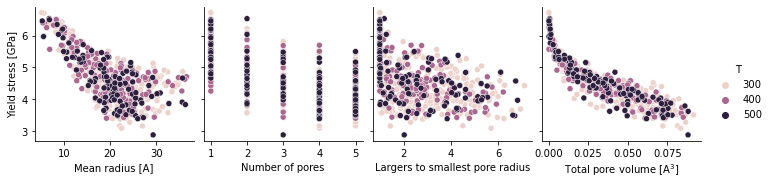

In [10]:
#data1=pd.melt(data["mean_radius", "strain_yield","elastic_modulous", "stress_yield","T"])
labels_x=["Mean radius [A]", "Number of pores", "Largers to smallest pore radius", "Total pore volume [A$^3$]"]
labels_y=["Yield stress [GPa]"]
g=sns.pairplot(data,y_vars=["stress_yield"],x_vars=["mean_radius","precipitate_number","large_to_low_ratio","pore volume"],hue="T")
for ax, lbl in zip(g.axes.flatten(), labels_x):
    # print(ax, lbl)
    ax.set_xlabel(f'{lbl}')
    
for ax, lbl in zip(g.axes.flatten(), labels_y):
    # print(ax, lbl)
    ax.set_ylabel(f'{lbl}')
    
plt.savefig("../image/pair-yieldstress.jpeg", edgecolor='white', dpi=1200,  transparent=True) #facecolor='black',

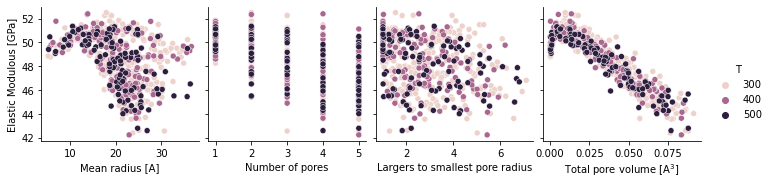

In [11]:
labels_x=["Mean radius [A]", "Number of pores", "Largers to smallest pore radius", "Total pore volume [A$^3$]"]
labels_y=["Elastic Modulous [GPa]"]
g=sns.pairplot(data,y_vars=["elastic_modulous"],x_vars=["mean_radius","precipitate_number","large_to_low_ratio","pore volume"],hue="T")
for ax, lbl in zip(g.axes.flatten(), labels_x):
    # print(ax, lbl)
    ax.set_xlabel(f'{lbl}')
    
for ax, lbl in zip(g.axes.flatten(), labels_y):
    # print(ax, lbl)
    ax.set_ylabel(f'{lbl}')
plt.savefig("../image/pair-elastic.jpeg", edgecolor='white', dpi=1200,  transparent=True) #facecolor='black',

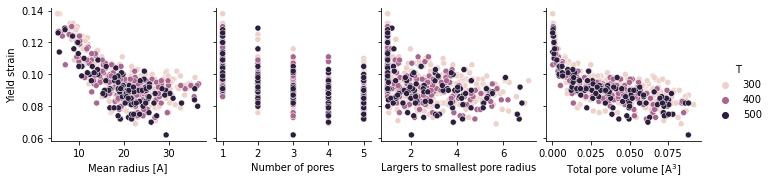

In [12]:
labels_x=["Mean radius [A]", "Number of pores", "Largers to smallest pore radius", "Total pore volume [A$^3$]"]
labels_y=["Yield strain"]
g=sns.pairplot(data,y_vars=["strain_yield"],x_vars=["mean_radius","precipitate_number","large_to_low_ratio","pore volume"],hue="T")
for ax, lbl in zip(g.axes.flatten(), labels_x):
    # print(ax, lbl)
    ax.set_xlabel(f'{lbl}')
    
for ax, lbl in zip(g.axes.flatten(), labels_y):
    # print(ax, lbl)
    ax.set_ylabel(f'{lbl}')
plt.savefig("../image/pair-yieldstrain.jpeg", edgecolor='white', dpi=1200,  transparent=True) #facecolor='black',

In [13]:
#sns.pairplot(data,y_vars=["elastic ratio"],x_vars=["mean_radius","precipitate_number","large_to_low_ratio","pore volume"],hue="T")

The data doe show trend line but does not show an outlier! make sure using the boxplot!

In [14]:
def add_median_labels(ax, fmt='.3f'):
    """Credits: https://stackoverflow.com/a/63295846/4865723
    """
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines_per_box = int(len(lines) / len(boxes))
    for median in lines[4:len(lines):lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if (median.get_xdata()[1] - median.get_xdata()[0]) == 0 else y
        text = ax.text(x, y, f'{value:{fmt}}', ha='center', va='center',
                       fontweight='bold', color='white')
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground=median.get_color()),
            path_effects.Normal(),
        ])

The average of yield strain for different Temperatures is: 
T
300    0.095117
400    0.094323
500    0.091764
Name: strain_yield, dtype: float64


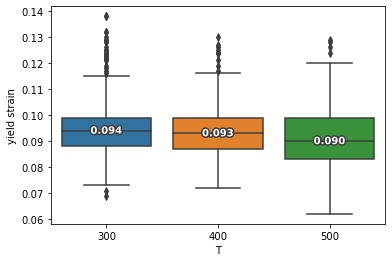

In [15]:
data_1=pd.melt(data[["T","strain_yield"]],id_vars="T",value_vars="strain_yield",value_name="yield strain")
plot_1=sns.boxplot(data=data_1,x="T",y="yield strain")
add_median_labels(plot_1)
averages=data.groupby (["T"])["strain_yield"].mean()
print("The average of yield strain for different Temperatures is: ")
print(averages)

The average of yield stress [GPa] for different Temperatures is: 
T
300    4.567810
400    4.645972
500    4.584749
Name: stress_yield, dtype: float64


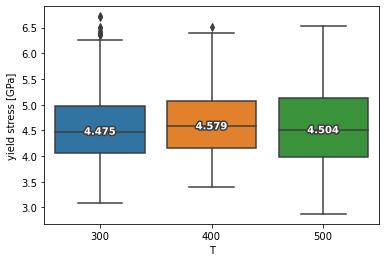

In [16]:
data_2=pd.melt(data[["T","stress_yield"]],id_vars="T",value_vars="stress_yield",value_name="yield stress [GPa]")
plot_2=sns.boxplot(data=data_2,x="T",y="yield stress [GPa]")
add_median_labels(plot_2)
averages=data.groupby (["T"])["stress_yield"].mean()
print("The average of yield stress [GPa] for different Temperatures is: ")
print(averages)
plt.savefig("../image/boxplot-yieldstrain.jpeg", edgecolor='white', dpi=1200,  transparent=True) #facecolor='black',

The average of Elastic Modulous [GPa] for different Temperatures is: 
T
300    48.581935
400    48.703956
500    48.265140
Name: elastic_modulous, dtype: float64


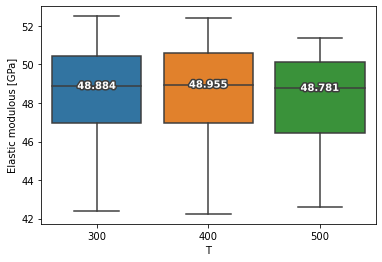

In [17]:
data_3=pd.melt(data[["T","elastic_modulous"]],id_vars="T",value_vars="elastic_modulous",value_name="Elastic modulous [GPa]")
plot_3=sns.boxplot(data=data_3,x="T",y="Elastic modulous [GPa]")
add_median_labels(plot_3)
averages=data.groupby (["T"])["elastic_modulous"].mean()
print("The average of Elastic Modulous [GPa] for different Temperatures is: ")
print(averages)

In [18]:
#data_4=pd.melt(data[["T","elastic ratio"]],id_vars="T",value_vars="elastic_modulous",value_name="Elastic modulous [GPa]")
#sns.boxplot(data=data_4,x="T",y="Elastic modulous [GPa]")

<AxesSubplot:xlabel='strain_yield'>

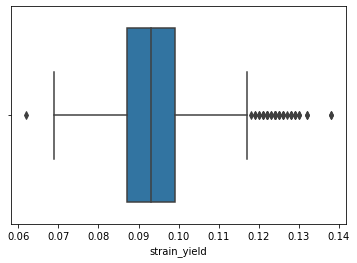

In [19]:
sns.boxplot(data=data,x="strain_yield",hue="T")
#fig,(ax1,ax2,ax3,ax4)=plt.subplots(1,4)
#ax1.boxplot(data=data,x="strain_yield",y="T")
#ax2.boxplot(data=data,x="strain_yield",hue="T")
#ax3.boxplot(data=data,x="strain_yield",hue="T")
#ax4.boxplot(data=data,x="strain_yield",hue="T")

In [20]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
run,622.0,310.114148,179.195028,1.000000,155.250000,310.500000,464.750000,620.000000
precipitate_number,622.0,3.020900,1.466056,1.000000,2.000000,3.000000,4.000000,5.000000
mean_radius,622.0,20.343853,6.081243,5.240198,16.731998,20.702967,24.186841,36.571664
std_radius,622.0,5.601776,4.049377,0.000000,1.248857,6.116499,8.986932,14.592060
volume_ratio,622.0,0.042360,0.029773,0.000147,0.015569,0.040975,0.066298,0.099929
large_to_low_ratio,622.0,2.558812,1.487454,1.000000,1.137532,2.241900,3.579724,7.099830
real_volume_ratio,622.0,0.966064,0.023789,0.908426,0.948301,0.967311,0.987343,0.999891
elastic_modulous,622.0,48.557495,2.176351,42.241362,46.822460,48.874325,50.434055,52.502700
stress_yield,622.0,4.591038,0.733779,2.874378,4.074037,4.499347,4.999753,6.720440
strain_yield,622.0,0.094318,0.012065,0.062000,0.087000,0.093000,0.099000,0.138000


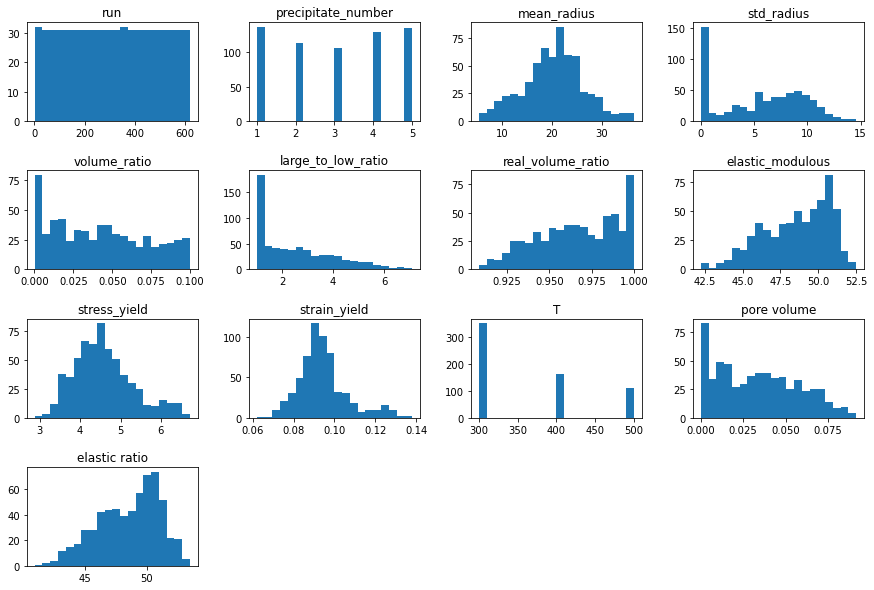

In [21]:
#distribution of the feature values
data.hist(figsize=(15,10),bins=20,grid=False)
plt.subplots_adjust(hspace=0.5);

The distribution of the feature values shows for all the aloying elements, temperature, and material properties is reasonable and in the expexted range. Thus, we do not have any ourliers in all the data presented in these columns.

# Scatterplots of material properties against design factors at @ Temperature= 300, 400, and 500 (K)

<AxesSubplot:>

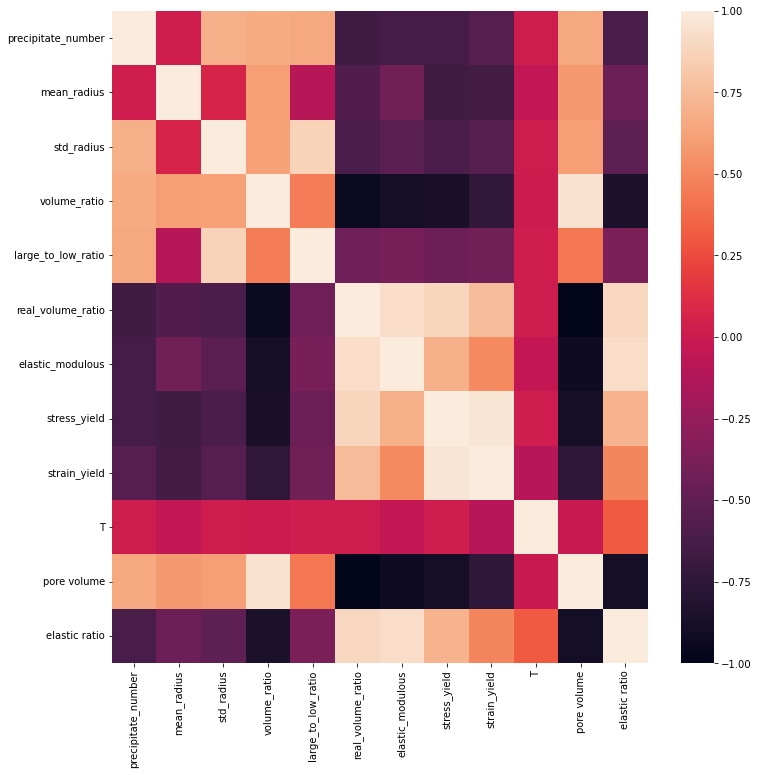

In [22]:
plt.subplots(figsize=(12,12))
sns.heatmap(data.iloc[:,1:].corr(), vmin=-1, vmax=1)

In [23]:
features=['elastic_modulous', 'stress_yield', 'strain_yield']

In [24]:
def heatmaps(column,ncol,prop,label1,label2):

    fig, axs = plt.subplots(2, 2, figsize=(17, 10))
    fig.subplots_adjust(wspace=0.5,hspace=1)
    axs = axs.ravel()
    for i in range(len(column)):
        col=[];col.append(column[i]) ;col+=prop
        labels=[];labels.append(label1[i]);labels+=label2
        print(labels)
        sns.heatmap(data[col].corr(),vmin=-1, vmax=1,ax=axs[i])
        axs[i].set_xticklabels(labels,rotation=45)
        axs[i].set_yticklabels(labels)
#    fig,axes=plt.subplots(nrow,ncol,figsize=fig_size)
#    fig.subplots_adjust(wspace=0.5,hspace=0.5)
#    col=[];col.append(column)
#    print(column)
#    print(list(column))
#    for i,col in column:
#        print(i,col)
#        ax = axes.flatten()[i]
#        ll=col+list(prop)
#        print(ll)
#        sns.heatmap(data[ll].corr(),vmin=-1, vmax=1)

['Number of Pores', 'Elastic modulous (GPa)', 'Yield Stress (GPa)', 'Yield Strain']
['Temeprature (K)', 'Elastic modulous (GPa)', 'Yield Stress (GPa)', 'Yield Strain']
['Mean Radius(A)', 'Elastic modulous (GPa)', 'Yield Stress (GPa)', 'Yield Strain']
['Bulk Volume(A³)', 'Elastic modulous (GPa)', 'Yield Stress (GPa)', 'Yield Strain']


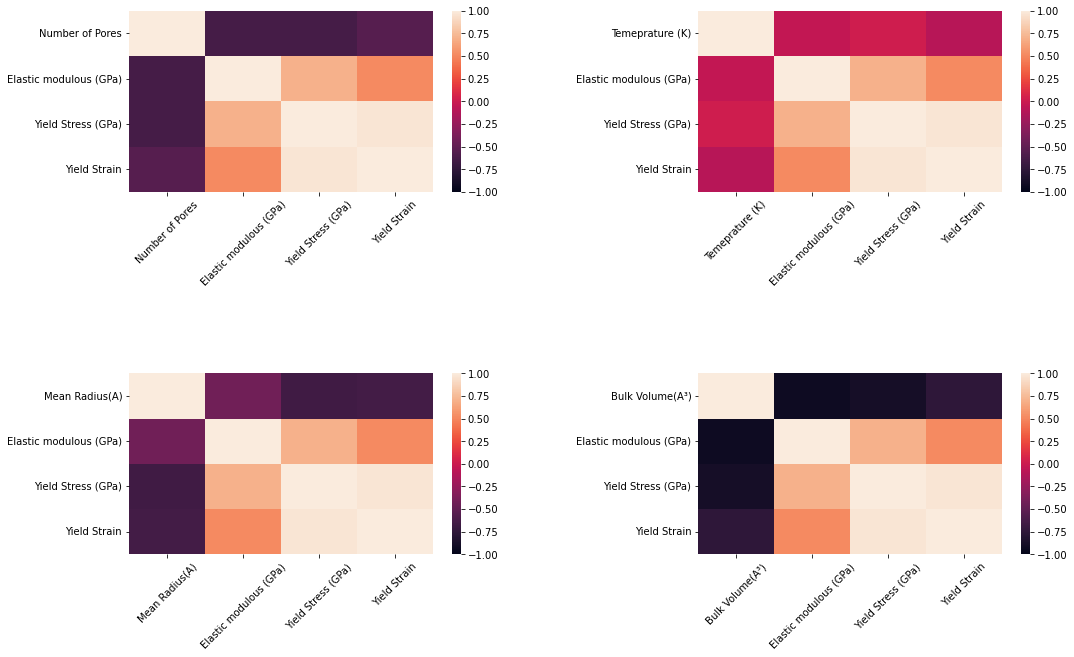

In [25]:
prop=['precipitate_number','T', 'mean_radius', 'pore volume'] #, 'large_to_low_ratio'
aa="H"
label1=["Number of Pores","Temeprature (K)",'Mean Radius(A)',"Bulk Volume(A\u00b3)"] #"Rmax/Rmin",
label2=['Elastic modulous (GPa)', 'Yield Stress (GPa)', 'Yield Strain']

heatmaps(prop,1,features,label1,label2)
plt.savefig("../image/Heatmap.jpeg", edgecolor='white', dpi=1200,  transparent=True,bbox_inches='tight') #facecolor='black',

# Modeling

In [26]:
#def standarddata(data,features,design):
#    x=data[design]
#    x=x.reset_index(drop=True)
#    y=data[features]
#    y=y.reset_index(drop=True)
#    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
#      # Standardizing the data
#    scaler = StandardScaler()
#    scaler.fit(x_train)
#    x_train = scaler.transform(x_train)
#    x_test = scaler.transform(x_test)

#    return X_train, X_test, y_train, y_test

In [27]:
#x=standarddata(data,features,prop)

In [28]:
l1=[col for col in data.columns if col not in prop]
#print(l1)
x=data.drop(l1,axis=1)
#print(x)
y=data[["elastic_modulous","stress_yield","strain_yield"]] #[features]

#y=y.reset_index(drop=True)
#print(y)
x_train_ori, x_test_ori, y_train, y_test= train_test_split(x, y, test_size=0.2, random_state=42,stratify=data["T"])

scaler = StandardScaler()
scaler.fit(x_train_ori)
x_train = scaler.transform(x_train_ori)
x_test = scaler.transform(x_test_ori)
print(x_test)

[[-1.39024343 -1.10369004  0.50243191 -1.34490555]
 [-0.03277588  1.43592862 -0.79813402  1.36799936]
 [-0.71150966  1.62332227 -0.79813402 -0.1059227 ]
 [-1.39024343  0.73671061  1.80299784 -0.91476811]
 [-0.71150966 -1.0805519   0.50243191 -1.23319672]
 [-0.03277588  0.44998222  0.50243191  0.14437856]
 [-1.39024343 -1.78029545  1.80299784 -1.41637249]
 [ 0.6459579   0.71449761 -0.79813402  1.49874378]
 [ 1.32469168 -0.15979203  0.50243191  0.14688324]
 [-1.39024343 -1.76943509 -0.79813402 -1.41587155]
 [-0.03277588 -1.4125604  -0.79813402 -0.8927269 ]
 [-1.39024343 -0.50377445 -0.79813402 -1.2452192 ]
 [-1.39024343 -2.48302982  1.80299784 -1.44843242]
 [ 1.32469168 -0.27659301 -0.79813402  0.96491249]
 [-0.03277588  1.22753437 -0.79813402  1.42226748]
 [-0.71150966  0.76987286  0.50243191  0.68455505]
 [-0.71150966  2.05959492  1.80299784  1.59141703]
 [ 1.32469168 -0.23207532  0.50243191  0.74700513]
 [ 1.32469168  0.0990013   1.80299784  1.52278873]
 [-1.39024343  1.88551027 -0.79

In [29]:
def spotcheck(X_train,X_test,y_train, y_test):
#  filterwarnings('ignore')
    models =[("LinearR", LinearRegression()) ,
          ("DTR", DecisionTreeRegressor()),  
          ('RF',RandomForestRegressor()),
          ('KNN', KNeighborsRegressor(n_neighbors=10)), 
          ("Ridge", RidgeCV())          
]

          #("SVR", SVR())]#,          ("SGDR", SGDRegressor())]#,
#                  ('ADA', AdaBoostRegressor()),
#          ('XGB',GradientBoostingRegressor()),
#          ('PAC',PassiveAggressiveRegressor())
    results = []
    names = []
    finalResults = []

    for name,model in models:
        model.fit(X_train, y_train)
        model_results = model.predict(X_test)
        r2score = r2_score(y_test, model_results) 
        MSE = mean_squared_error(y_test, model_results)
        MAE = mean_absolute_error(y_test, model_results)
        results.append(r2score)
        results.append(MSE)
        results.append(MAE)
        names.append(name)
        finalResults.append((name, r2score, MSE, MAE))
      
    finalResults.sort(key=lambda k:k[1],reverse=True)
    return finalResults

In [30]:
# Set Random Seed
np.random.seed(42)

# Run spot checking
proofstress_df = pd.DataFrame(spotcheck(x_train,x_test,y_train, y_test), columns=['Model Name', 'R2 Score', 'MSE', 'MAE'])
proofstress_df

,Model Name,R2 Score,MSE,MAE
0,KNN,0.878957,0.208559,0.250378
1,RF,0.868542,0.188323,0.233948
2,LinearR,0.863238,0.200350,0.256330
3,Ridge,0.863219,0.200394,0.256332
4,DTR,0.740721,0.303164,0.302381


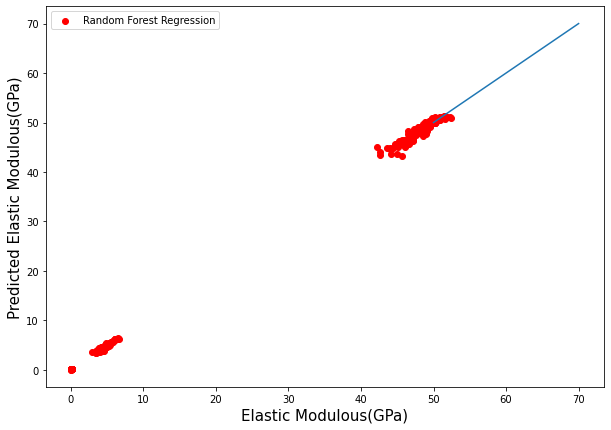

In [31]:
# Fit the model
model_RF = RandomForestRegressor()
model_RF.fit(x_train, y_train)

# Prediction
y_pred_RF = model_RF.predict(x_test)

# Plot the relation between y_test and y_pred
plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred_RF, c="r", label="Random Forest Regression")
plt.plot([50,70],[50,70],marker=None)

plt.xlabel("Elastic Modulous(GPa)", fontsize=15)
plt.ylabel("Predicted Elastic Modulous(GPa)", fontsize=15)
plt.legend()

## Optimize Decision tree branching

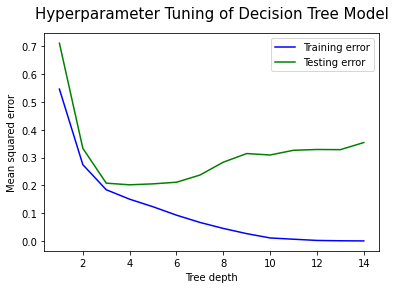

In [32]:
max_depths = range(1, 15)
training_error = []
testing_error = []
for max_depth in max_depths:
    model_1 = DecisionTreeRegressor(max_depth=max_depth)
    model_1.fit(x_train, y_train)
    training_error.append(mean_squared_error(y_train, model_1.predict(x_train)))
    testing_error.append(mean_squared_error(y_test, model_1.predict(x_test)))

plt.plot(max_depths, training_error, color='blue', label='Training error')
plt.plot(max_depths, testing_error, color='green', label='Testing error')
plt.xlabel('Tree depth')

plt.ylabel('Mean squared error')
plt.title('Hyperparameter Tuning of Decision Tree Model', pad=15, size=15)
plt.legend()

No handles with labels found to put in legend.


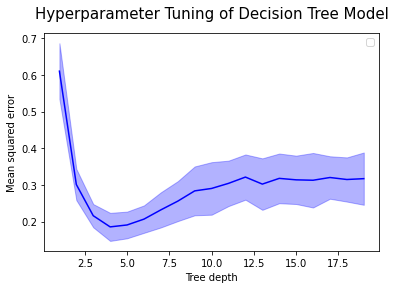

In [33]:
max_depths = range(1, 20)
error = []
error_std = []
num_split=10
kf=KFold(n_splits=num_split, shuffle=True,random_state=42)
for max_depth in max_depths:
    model_1 = DecisionTreeRegressor(max_depth=max_depth)
    cv_result_KF=cross_validate(model_1,x,y,cv=kf,return_estimator=True)
    scores= cross_val_score(model_1, x, y, cv=kf, scoring='neg_mean_squared_error')
    error.append(np.mean(np.abs(scores)))
    error_std.append(np.std(np.abs(scores)))

plt.plot(max_depths, error, color='blue')
plt.fill_between(max_depths, np.array(error)-np.array(error_std), np.array(error)+np.array(error_std),alpha=0.3, color="blue")
                          
                          
#plt.plot(max_depths, testing_error, color='green', label='Testing error')
plt.xlabel('Tree depth')

plt.ylabel('Mean squared error')
plt.title('Hyperparameter Tuning of Decision Tree Model', pad=15, size=15)
plt.legend()


In [34]:
index_min=error.index(min(error))
depth_min=max_depths[index_min]
print("The tree depth resulting minimum error is {} and the correspondig error is {}".format(depth_min,error[index_min]))

The tree depth resulting minimum error is 4 and the correspondig error is 0.1853858873916177


In [38]:
min_samples_leaf = range(1, 10)
n_estimators = range(1, 20)
max_depth=range(1, 10)
min_samples_split = range(2, 10)
min_samples_leaf = range(2, 20)
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}
#               'min_samples_split': min_samples_split,
#               'min_samples_leaf': min_samples_leaf,
#               'bootstrap': bootstrap
num_split=10
kf=KFold(n_splits=num_split, shuffle=True,random_state=42)
model_3 = RandomForestRegressor()

#rf_random = RandomizedSearchCV(estimator = model_3, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2)
rf_random = GridSearchCV( model_3, random_grid, cv = kf)

rf_random.fit(x_train,y_train.values.ravel())
cv_result_KF=cross_validate(rf_random,x,y,cv=kf,return_estimator=True)
scores= cross_val_score(rf_random, x, y.values.ravel(), cv=kf, scoring='neg_mean_squared_error')


ValueError: Found input variables with inconsistent numbers of samples: [497, 1491]

## Neural Network

In [39]:
print(y_test.head())

     elastic_modulous  stress_yield  strain_yield
407         50.709339      5.742948         0.112
201         46.670414      4.516173         0.098
174         48.590849      4.658272         0.098
528         51.083126      4.848428         0.092
465         52.350762      4.910327         0.093


In [40]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.optimizers import Adam

In [41]:
#Create the layers
n1=10 #neuron
n2=20 #neuron
n_input=x.shape[1]
input_layer=Input(shape=(n_input,),name='input_layer')
layer_1=Dense(n1,activation="linear",name='layer_1')(input_layer)
layer_2=Dense(n2,activation="linear",name='layer_2')(layer_1)
layer_3=Dense(n2,activation="linear",name='layer_3')(layer_2)
#layer_4=Dense(n2,activation="linear",name='layer_4')(layer_3)

#1st output
y1_output=Dense(3,activation="linear",name='y1_output')(layer_3)


#Define the model
model_nn=Model(inputs=input_layer,outputs=y1_output)#[,y3_output]

#MSummary of Model
model_nn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 4)]               0         
                                                                 
 layer_1 (Dense)             (None, 10)                50        
                                                                 
 layer_2 (Dense)             (None, 20)                220       
                                                                 
 layer_3 (Dense)             (None, 20)                420       
                                                                 
 y1_output (Dense)           (None, 3)                 63        
                                                                 
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________


In [42]:
## defining the optimiser and loss function
model_nn.compile(optimizer='Adam', loss='mse') #,'y3_output':'mse'
#my_callbacks = [
#    tf.keras.callbacks.EarlyStopping(patience=1),
#    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
#    tf.keras.callbacks.TensorBoard(log_dir='./logs'),]
###train the model
history=model_nn.fit(x_train,y_train,epochs=200, batch_size=100, validation_data=(x_test,y_test)) #  ,callbacks=my_callbacks

Epoch 1/200
5/5 [==============================] - 7s 1s/step - loss: 795.6454 - val_loss: 793.5308
Epoch 2/200
5/5 [==============================] - 0s 17ms/step - loss: 792.8221 - val_loss: 790.4835
Epoch 3/200
5/5 [==============================] - 0s 18ms/step - loss: 790.2003 - val_loss: 787.6171
Epoch 4/200
5/5 [==============================] - 0s 15ms/step - loss: 787.6561 - val_loss: 784.4694
Epoch 5/200
5/5 [==============================] - 0s 17ms/step - loss: 784.7523 - val_loss: 781.3073
Epoch 6/200
5/5 [==============================] - 0s 15ms/step - loss: 781.6836 - val_loss: 777.7343
Epoch 7/200
5/5 [==============================] - 0s 16ms/step - loss: 778.2158 - val_loss: 773.7860
Epoch 8/200
5/5 [==============================] - 0s 18ms/step - loss: 774.2734 - val_loss: 769.1490
Epoch 9/200
5/5 [==============================] - 0s 25ms/step - loss: 769.6811 - val_loss: 763.7814
Epoch 10/200
5/5 [==============================] - 0s 20ms/step - loss: 764.2822 - 

5/5 [==============================] - 0s 17ms/step - loss: 0.2297 - val_loss: 0.2230
Epoch 83/200
5/5 [==============================] - 0s 17ms/step - loss: 0.2300 - val_loss: 0.2221
Epoch 84/200
5/5 [==============================] - 0s 15ms/step - loss: 0.2298 - val_loss: 0.2236
Epoch 85/200
5/5 [==============================] - 0s 14ms/step - loss: 0.2297 - val_loss: 0.2245
Epoch 86/200
5/5 [==============================] - 0s 15ms/step - loss: 0.2293 - val_loss: 0.2230
Epoch 87/200
5/5 [==============================] - 0s 13ms/step - loss: 0.2292 - val_loss: 0.2225
Epoch 88/200
5/5 [==============================] - 0s 15ms/step - loss: 0.2292 - val_loss: 0.2231
Epoch 89/200
5/5 [==============================] - 0s 14ms/step - loss: 0.2290 - val_loss: 0.2224
Epoch 90/200
5/5 [==============================] - 0s 16ms/step - loss: 0.2288 - val_loss: 0.2224
Epoch 91/200
5/5 [==============================] - 0s 14ms/step - loss: 0.2292 - val_loss: 0.2230
Epoch 92/200
5/5 [=====

5/5 [==============================] - 0s 17ms/step - loss: 0.2267 - val_loss: 0.2221
Epoch 165/200
5/5 [==============================] - 0s 13ms/step - loss: 0.2271 - val_loss: 0.2202
Epoch 166/200
5/5 [==============================] - 0s 15ms/step - loss: 0.2276 - val_loss: 0.2191
Epoch 167/200
5/5 [==============================] - 0s 18ms/step - loss: 0.2275 - val_loss: 0.2222
Epoch 168/200
5/5 [==============================] - 0s 14ms/step - loss: 0.2272 - val_loss: 0.2225
Epoch 169/200
5/5 [==============================] - 0s 16ms/step - loss: 0.2269 - val_loss: 0.2188
Epoch 170/200
5/5 [==============================] - 0s 17ms/step - loss: 0.2266 - val_loss: 0.2202
Epoch 171/200
5/5 [==============================] - 0s 17ms/step - loss: 0.2268 - val_loss: 0.2204
Epoch 172/200
5/5 [==============================] - 0s 14ms/step - loss: 0.2271 - val_loss: 0.2187
Epoch 173/200
5/5 [==============================] - 0s 15ms/step - loss: 0.2266 - val_loss: 0.2206
Epoch 174/200


4/4 [==============================] - 0s 3ms/step - loss: 0.2215


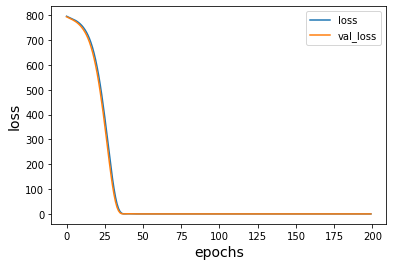

In [43]:
# Evalute the Model
model_nn.evaluate(x_test, y_test)

# Plot loss VS epochs graph
pd.DataFrame(history.history).plot()
plt.ylabel('loss', fontsize=14)
plt.xlabel('epochs', fontsize=14)
plt.savefig("../image/loss-epoch.jpeg", edgecolor='white', dpi=1200,  transparent=True,bbox_inches='tight') #facecolor='black',

In [44]:
predictions = model_nn.predict(x_test)
pred_1=predictions[:,0]
pred_2=predictions[:,1]
pred_3=predictions[:,2]

4/4 [==============================] - 1s 5ms/step


No handles with labels found to put in legend.


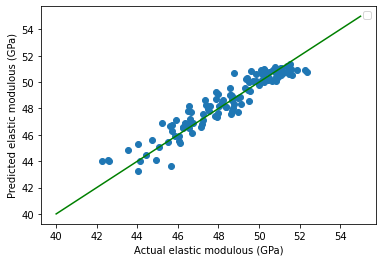

In [45]:
plt.scatter(y_test["elastic_modulous"],pred_1 ) #,label="Neural Network"
plt.xlabel('Actual elastic modulous (GPa)')
plt.ylabel('Predicted elastic modulous (GPa)')
plt.plot([40,55],[40,55],marker=None,color="green")
#plt.scatter(y_test["elastic_modulous"], y_pred_RF[:,0], c="r", label="Random Forest Regression")
plt.legend()
plt.savefig("../image/actual-predicted-elastic.jpeg", edgecolor='white', dpi=1200,  transparent=True,bbox_inches='tight') #facecolor='black',

No handles with labels found to put in legend.


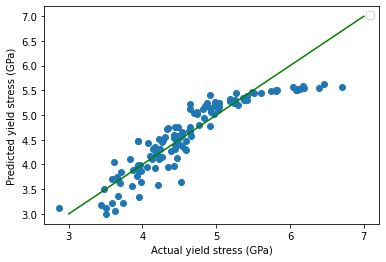

In [46]:
plt.scatter(y_test["stress_yield"],pred_2 ) #,label="Neural Network"
plt.xlabel('Actual yield stress (GPa)')
plt.ylabel('Predicted yield stress (GPa)')
plt.plot([3,7],[3,7],marker=None,color="green")
#plt.scatter(y_test["stress_yield"], y_pred_RF[:,1], c="r", label="Random Forest Regression")
plt.legend()
plt.savefig("../image/actual-predicted-stress.jpeg", edgecolor='white', dpi=1200,  transparent=True,bbox_inches='tight') #facecolor='black',

No handles with labels found to put in legend.


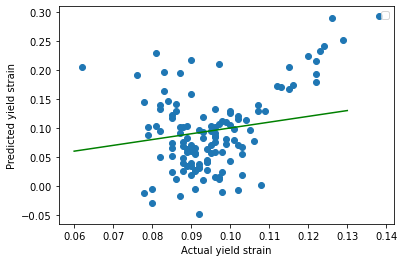

In [47]:
plt.scatter(y_test["strain_yield"],pred_3 ) #,label="Neural Network"
plt.xlabel('Actual yield strain')
plt.ylabel('Predicted yield strain')
plt.plot([0.06,0.13],[0.06,0.13],marker=None,color="green")
#plt.scatter(y_test["strain_yield"], y_pred_RF[:,2], c="r", label="Random Forest Regression")
plt.legend()
plt.savefig("../image/actual-predicted-strain.jpeg", edgecolor='white', dpi=1200,  transparent=True,bbox_inches='tight') #facecolor='black',

In [48]:
rf_results = model_RF.predict(x_test)
r2score_rf = r2_score(y_test, rf_results) 
MSE_rf = mean_squared_error(y_test, rf_results)
MAE_rf = mean_absolute_error(y_test, rf_results)
print(r2score_rf,MSE_rf,MAE_rf)

0.86683434956556 0.18709569598226264 0.23512150806895923


In [49]:
nn_results = model_nn.predict(x_test)
r2score_nn = r2_score(y_test, nn_results) 
MSE_nn = mean_squared_error(y_test, nn_results)
MAE_nn = mean_absolute_error(y_test, nn_results)
print(r2score_nn,MSE_nn,MAE_nn)

4/4 [==============================] - 0s 3ms/step
-8.598296646082238 0.22152492937359058 0.2945023191379405


In [50]:
nn_results_train = model_nn.predict(x_train)
r2score_nn_train = r2_score(y_train, nn_results_train) 
MSE_nn_train = mean_squared_error(y_train, nn_results_train)
MAE_nn_train = mean_absolute_error(y_train, nn_results_train)
print(r2score_nn_train,MSE_nn_train,MAE_nn_train)

16/16 [==============================] - 0s 2ms/step
-9.018943947276577 0.2257614191498045 0.29290437259116703


In [51]:
stress_treshold=4.0

def my_fun (df,var1,var2,var3):
    df[var3]= np.where((df[var1]-var2)<0, (var2-df[var1])/var2, 0)
    return df

data_risk = my_fun(data,"stress_yield",stress_treshold,"risk_factor")

print(data_risk["risk_factor"])

0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
617    0.000000
618    0.000000
619    0.089387
620    0.000000
621    0.000000
Name: risk_factor, Length: 622, dtype: float64


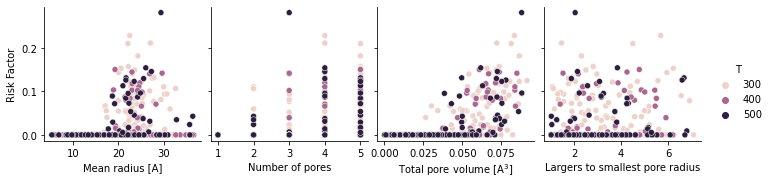

In [52]:
labels_x=["Mean radius [A]", "Number of pores", "Total pore volume [A$^3$]","Largers to smallest pore radius"]
labels_y=["Risk Factor"]
g=sns.pairplot(data_risk,y_vars=["risk_factor"],x_vars=["mean_radius","precipitate_number","pore volume", "large_to_low_ratio"],hue="T")
for ax, lbl in zip(g.axes.flatten(), labels_x):
    # print(ax, lbl)
    ax.set_xlabel(f'{lbl}')
    
for ax, lbl in zip(g.axes.flatten(), labels_y):
    # print(ax, lbl)
    ax.set_ylabel(f'{lbl}')

plt.savefig("../image/pain-risk.jpeg", edgecolor='white', dpi=1200,  transparent=True,bbox_inches='tight') #facecolor='black',

0
1
2


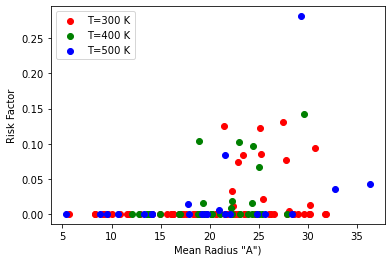

In [53]:
color=["r","g","b"]
label=[300,400,500]

for j in range(3):
    print(j)
    aa=x_test_ori.index[x_test_ori["T"]==label[j]].tolist()
    x_T=[];y_T=[]

    for i in aa:
        x_T.append(x_test_ori.loc[i,["mean_radius"]].item())
        y_T.append(np.where((y_test.loc[i,["stress_yield"]].item()-stress_treshold)<0, (stress_treshold-y_test.loc[i,["stress_yield"]].item())/stress_treshold, 0))
        

    plt.scatter(x_T, y_T , label="T="+str(label[j])+" K",color=color[j] ) #pred_2

plt.xlabel('Mean Radius "A")')
plt.ylabel('Risk Factor')
#plt.plot([40,55],[40,55],marker=None,color="green")
#plt.scatter(y_test["elastic_modulous"], y_pred_RF[:,0], c="r", label="Random Forest Regression")
plt.legend()

0
1
2


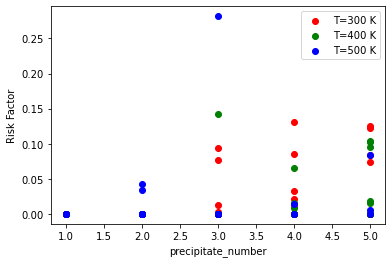

In [54]:
color=["r","g","b"]
label=[300,400,500]

for j in range(3):
    print(j)
    aa=x_test_ori.index[x_test_ori["T"]==label[j]].tolist()
    x_T=[];y_T=[]

    for i in aa:
        x_T.append(x_test_ori.loc[i,["precipitate_number"]].item())
        y_T.append(np.where((y_test.loc[i,["stress_yield"]].item()-stress_treshold)<0, (stress_treshold-y_test.loc[i,["stress_yield"]].item())/stress_treshold, 0))
        

    plt.scatter(x_T, y_T , label="T="+str(label[j])+" K",color=color[j] ) #pred_2

plt.xlabel('precipitate_number')
plt.ylabel('Risk Factor')
#plt.plot([40,55],[40,55],marker=None,color="green")
#plt.scatter(y_test["elastic_modulous"], y_pred_RF[:,0], c="r", label="Random Forest Regression")
plt.legend()

0
1
2


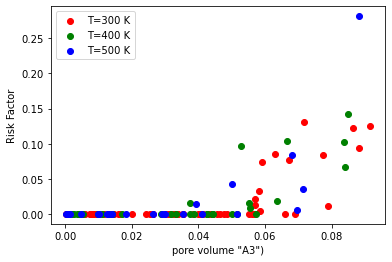

In [55]:
color=["r","g","b"]
label=[300,400,500]

for j in range(3):
    print(j)
    aa=x_test_ori.index[x_test_ori["T"]==label[j]].tolist()
    x_T=[];y_T=[]

    for i in aa:
        x_T.append(x_test_ori.loc[i,["pore volume"]].item())
        y_T.append(np.where((y_test.loc[i,["stress_yield"]].item()-stress_treshold)<0, (stress_treshold-y_test.loc[i,["stress_yield"]].item())/stress_treshold, 0))
        

    plt.scatter(x_T, y_T , label="T="+str(label[j])+" K",color=color[j] ) #pred_2

plt.xlabel('pore volume "A3")')
plt.ylabel('Risk Factor')
#plt.plot([40,55],[40,55],marker=None,color="green")
#plt.scatter(y_test["elastic_modulous"], y_pred_RF[:,0], c="r", label="Random Forest Regression")
plt.legend()

In [56]:
stress_treshold=4.0

def my_fun (df,var1,var2,var3):
    df[var3]= np.where((df[var1]-var2)<0, 1, 0)
    return df

data_risk = my_fun(data,"stress_yield",stress_treshold,"risk_factor")
print(data_risk.head())


   run  precipitate_number                                        all_radious  \
0    1                   2            [33.880196919691365, 11.01144511125755]   
1    2                   5  [7.707413063642578, 19.77443849890375, 17.3601...   
2    3                   5  [20.63792849453621, 27.422276752232076, 10.969...   
3    4                   1                               [10.747905651404697]   
4    5                   1                               [15.081813488962657]   

   mean_radius  std_radius  volume_ratio  large_to_low_ratio  \
0    22.445821   11.434376      0.041116            3.076817   
1    16.259450    8.617053      0.041572            4.640676   
2    20.888019    5.484199      0.055524            2.499790   
3    10.747906    0.000000      0.001269            1.000000   
4    15.081813    0.000000      0.003506            1.000000   

   real_volume_ratio  elastic_modulous  stress_yield  strain_yield    T  \
0           0.973402         49.588162      4.868035 

In [57]:

x_risk=data_risk[['mean_radius', 'pore volume',"T"]] #'precipitate_number','T', 
#print(x)
y_risk=(data_risk[["risk_factor"]]) #[features]

In [58]:
x_train_risk1, x_test_risk1, y_train_risk, y_test_risk= train_test_split(x_risk, y_risk, test_size=0.2, random_state=42,stratify=data["T"])

x_train_risk2=x_train_risk1[['mean_radius', 'pore volume']]
x_test_risk2=x_test_risk1[['mean_radius', 'pore volume']]

x_train_risk2_nonorrm=x_train_risk1[['mean_radius', 'pore volume']]
x_test_risk2_nonorrm=x_test_risk1[['mean_radius', 'pore volume']]

scaler_risk = StandardScaler()
scaler_risk.fit(x_train_risk1)
x_train_risk = scaler_risk.transform(x_train_risk1)
x_test_risk = scaler_risk.transform(x_test_risk1)

scaler_risk2 = StandardScaler()
scaler_risk2.fit(x_train_risk2)
x_train_risk2 = scaler_risk2.transform(x_train_risk2)
x_test_risk2= scaler_risk2.transform(x_test_risk2)
print(x_test_risk2_nonorrm)

     mean_radius  pore volume
407    13.663555     0.002582
201    28.992108     0.066047
174    30.123173     0.031566
528    24.771789     0.012645
465    13.803211     0.005195
..           ...          ...
494    22.229054     0.011129
436    18.821817     0.016910
399    19.429353     0.031637
214    18.899438     0.026379
570    14.095862     0.013207

[125 rows x 2 columns]


In [59]:
clf = MLPClassifier(solver='lbfgs', alpha=1,hidden_layer_sizes=(20, 3), random_state=1)
clf.fit(x_train_risk2,y_train_risk)
y_pred_risk=clf.predict(x_test_risk2)
print(y_pred_risk.shape)
accuracy = accuracy_score(y_true=y_test_risk, y_pred=y_pred_risk)
print(accuracy)
#plt.plot(clf.loss_curve_)
#plt.plot(clf.validation_scores_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


(125,)
0.912


In [60]:
print(y_test_risk.shape)
print("Training set score: %f" % clf.score(x_train_risk2, y_train_risk))
print("Test set score: %f" % clf.score(x_test_risk2, y_test_risk))
print(x_test_risk2)

(125, 1)
Training set score: 0.883300
Test set score: 0.912000
[[-1.10369004 -1.34490555]
 [ 1.43592862  1.36799936]
 [ 1.62332227 -0.1059227 ]
 [ 0.73671061 -0.91476811]
 [-1.0805519  -1.23319672]
 [ 0.44998222  0.14437856]
 [-1.78029545 -1.41637249]
 [ 0.71449761  1.49874378]
 [-0.15979203  0.14688324]
 [-1.76943509 -1.41587155]
 [-1.4125604  -0.8927269 ]
 [-0.50377445 -1.2452192 ]
 [-2.48302982 -1.44843242]
 [-0.27659301  0.96491249]
 [ 1.22753437  1.42226748]
 [ 0.76987286  0.68455505]
 [ 2.05959492  1.59141703]
 [-0.23207532  0.74700513]
 [ 0.0990013   1.52278873]
 [ 1.88551027 -0.42368339]
 [ 0.28970893 -0.21662966]
 [-0.67360473 -0.17638776]
 [ 0.51381309  1.85440867]
 [-1.83782388 -1.38531443]
 [-1.9862159  -1.42956382]
 [-0.34401479 -0.8312787 ]
 [-1.69506023 -1.12900194]
 [ 0.87827419 -0.33101015]
 [ 1.28342804  1.04372649]
 [-0.67498316  0.4270737 ]
 [ 0.20471794  0.06072217]
 [ 1.49287318  2.31026085]
 [ 0.34834248  0.90596896]
 [-2.42079403 -1.44676264]
 [ 0.33876859  0.94

In [61]:
y_pred_risk=clf.predict(x_test_risk2)
print(y_test_risk["risk_factor"].shape)
print(y_pred_risk.shape)

(125,)
(125,)


No handles with labels found to put in legend.


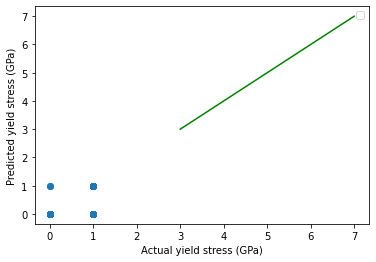

In [62]:
plt.scatter(y_test_risk["risk_factor"],y_pred_risk ) #,label="Neural Network"
plt.xlabel('Actual yield stress (GPa)')
plt.ylabel('Predicted yield stress (GPa)')
plt.plot([3,7],[3,7],marker=None,color="green")
plt.legend()
#plt.savefig("../image/actual-predicted-stress.jpeg", edgecolor='white', dpi=1200,  transparent=True,bbox_inches='tight') #facecolor='black',

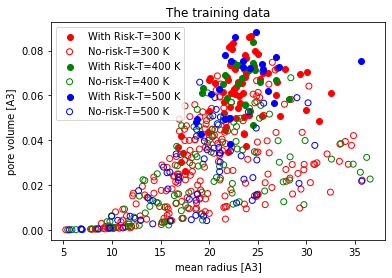

In [63]:
color=["r","g","b"]
label=[300,400,500]
facecolors=['color[j]','none']
for j in range(3):
    aa=x_train_risk1.index[x_train_risk1["T"]==label[j]].tolist()
    x0_T=[];y0_T=[];x1_T=[];y1_T=[]

    for i in aa:
        if (y_train_risk.loc[i,["risk_factor"]].item()==0.0):
            x0_T.append(x_train_risk1.loc[i,["mean_radius"]].item())
            y0_T.append(x_train_risk1.loc[i,["pore volume"]].item())
        else:
            x1_T.append(x_train_risk1.loc[i,["mean_radius"]].item())
            y1_T.append(x_train_risk1.loc[i,["pore volume"]].item())
        

    plt.scatter(x1_T, y1_T , label="With Risk-T="+str(label[j])+" K",color=color[j] ) #pred_2
    plt.scatter(x0_T, y0_T , label="No-risk-T="+str(label[j])+" K",color=color[j],facecolor='none' ) #pred_2

plt.xlabel('mean radius [A3]')
plt.ylabel('pore volume [A3]')
plt.title("The training data")
#plt.plot([40,55],[40,55],marker=None,color="green")
#plt.scatter(y_test["elastic_modulous"], y_pred_RF[:,0], c="r", label="Random Forest Regression")
plt.legend()
plt.savefig("../image/risk-train", edgecolor='white', dpi=1200,  transparent=True,bbox_inches='tight') #facecolor='black',

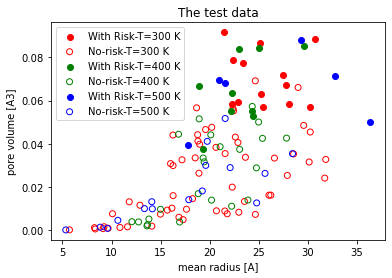

In [64]:
color=["r","g","b"]
label=[300,400,500]
facecolors=['color[j]','none']
for j in range(3):
    aa=x_test_risk1.index[x_test_risk1["T"]==label[j]].tolist()
    x0_T=[];y0_T=[];x1_T=[];y1_T=[]

    for i in aa:
        if (y_test_risk.loc[i,["risk_factor"]].item()==0.0):
            x0_T.append(x_test_risk1.loc[i,["mean_radius"]].item())
            y0_T.append(x_test_risk1.loc[i,["pore volume"]].item())
        else:
            x1_T.append(x_test_risk1.loc[i,["mean_radius"]].item())
            y1_T.append(x_test_risk1.loc[i,["pore volume"]].item())
        

    plt.scatter(x1_T, y1_T , label="With Risk-T="+str(label[j])+" K",color=color[j] ) #pred_2
    plt.scatter(x0_T, y0_T , label="No-risk-T="+str(label[j])+" K",color=color[j],facecolor='none' ) #pred_2

plt.xlabel('mean radius [A]')
plt.ylabel('pore volume [A3]')
plt.title("The test data")
#plt.plot([40,55],[40,55],marker=None,color="green")
#plt.scatter(y_test["elastic_modulous"], y_pred_RF[:,0], c="r", label="Random Forest Regression")
plt.legend()
plt.savefig("../image/risk-test", edgecolor='white', dpi=1200,  transparent=True,bbox_inches='tight') #facecolor='black',

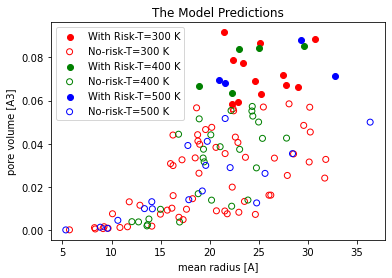

In [65]:
color=["r","g","b"]
label=[300,400,500]
facecolors=['color[j]','none']

index_300=[];index_400=[];index_500=[]



for j in range(3):
    x0_300=[];x1_300=[];y0_300=[];y1_300=[];
    row_num=[]
    counter=0
    for i in range(len(y_test_risk)):
        if (x_test_risk1.iloc[i,-1]==label[j]):
            if (y_pred_risk[i]==0.0):
                x0_300.append(x_test_risk1.iloc[i,0].item())
                y0_300.append(x_test_risk1.iloc[i,1].item())
            elif (y_pred_risk[i]==1.0):
                x1_300.append(x_test_risk1.iloc[i,0].item())
                y1_300.append(x_test_risk1.iloc[i,1].item())
            else:
                print("Error 300 K")  
    plt.scatter(x1_300, y1_300 , label="With Risk-T="+str(label[j])+" K",color=color[j] ) #pred_2
    plt.scatter(x0_300, y0_300 , label="No-risk-T="+str(label[j])+" K",color=color[j],facecolor='none' ) #pred_2

plt.xlabel('mean radius [A]')
plt.ylabel('pore volume [A3]')
plt.title("The Model Predictions")
#plt.plot([40,55],[40,55],marker=None,color="green")
#plt.scatter(y_test["elastic_modulous"], y_pred_RF[:,0], c="r", label="Random Forest Regression")
plt.legend()
plt.savefig("../image/risk-predict", edgecolor='white', dpi=1200,  transparent=True,bbox_inches='tight') #facecolor='black',

clf_0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


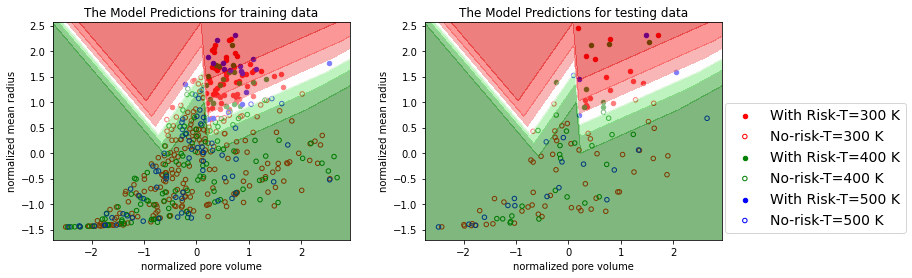

In [66]:
color=["r","g","b"]
label=[300,400,500]
facecolors=['color[j]','none']

index_300=[];index_400=[];index_500=[]

fig, axs = plt.subplots(1, 2,figsize=(12, 4)) #, 
fig.subplots_adjust(wspace=0.25,hspace=0.25)

axs = axs.ravel()

from  matplotlib.colors import LinearSegmentedColormap
cmap_rg=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256)

c = [ "darkgreen","green","palegreen","white","lightcoral","red","darkred"]
v = [0,.15,.4,.5,0.6,.9,1.]
l = list(zip(v,c))
cmap_rg2=LinearSegmentedColormap.from_list('rg',l, N=256)


alpha=[0.08] 
counter_tmp=0
for ii in range(len(alpha)):

    name="clf_"+str(counter_tmp)
    print(name)
    name = MLPClassifier(solver='lbfgs', alpha=alpha[ii],hidden_layer_sizes=(10, 2), random_state=1)
    name.fit(x_train_risk2,y_train_risk)
    y_pred_risk=name.predict(x_train_risk2)

    for j in range(3):
        x0_300=[];x1_300=[];y0_300=[];y1_300=[];
        row_num=[]
        counter=0
        for i in range(len(y_train_risk)):
            if (x_train_risk1.iloc[i,-1]==label[j]):
                if (y_pred_risk[i]==0.0):
                    x0_300.append(x_train_risk2[i,0].item())
                    y0_300.append(x_train_risk2[i,1].item())
                elif (y_pred_risk[i]==1.0):
                    x1_300.append(x_train_risk2[i,0].item())
                    y1_300.append(x_train_risk2[i,1].item())
                else:
                    print("Error 300 K")  
        axs[0].scatter(x1_300, y1_300 , label="With Risk-T="+str(label[j])+" K",color=color[j],s=20 ) #pred_2
        axs[0].scatter(x0_300, y0_300 , label="No-risk-T="+str(label[j])+" K",color=color[j],facecolor='none',s=20 ) #pred_2


    h = 0.002  # step size in the mesh
    x_min, x_max = x_train_risk2[:,0].min()-0.25 , x_train_risk2[:,0].max()+0.25
    y_min, y_max = x_train_risk2[:,1].min()-0.25 , x_train_risk2[:,1].max()+0.25
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    
    if hasattr(name, "decision_function"):
        Z = name.decision_function(np.column_stack([xx.ravel(), yy.ravel()]))
    else:
        Z = name.predict_proba(np.column_stack([xx.ravel(), yy.ravel()]))[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        axs[0].contourf(xx, yy, Z, cmap=cmap_rg2, alpha=0.5) #plt.cm.RdBu

    score=name.score(x_train_risk2, y_train_risk)
    axs[0].title.set_text("The Model Predictions for training data".format(round(score,4)))


    
    axs[0].set_xlabel('normalized pore volume')
    axs[0].set_ylabel('normalized mean radius')

    
    
    y_pred_risk=name.predict(x_test_risk2)

    for j in range(3):
        x0_300=[];x1_300=[];y0_300=[];y1_300=[];
        row_num=[]
        counter=0
        for i in range(len(y_test_risk)):
            if (x_test_risk1.iloc[i,-1]==label[j]):
                if (y_pred_risk[i]==0.0):
                    x0_300.append(x_test_risk2[i,0].item())
                    y0_300.append(x_test_risk2[i,1].item())
                elif (y_pred_risk[i]==1.0):
                    x1_300.append(x_test_risk2[i,0].item())
                    y1_300.append(x_test_risk2[i,1].item())
                else:
                    print("Error 300 K")  
        axs[1].scatter(x1_300, y1_300 , label="With Risk-T="+str(label[j])+" K",color=color[j],s=20 ) #pred_2
        axs[1].scatter(x0_300, y0_300 , label="No-risk-T="+str(label[j])+" K",color=color[j],facecolor='none',s=20 ) #pred_2


    h = 0.002  # step size in the mesh
    x_min, x_max = x_train_risk2[:,0].min()-0.25 , x_train_risk2[:,0].max()+0.25
    y_min, y_max = x_train_risk2[:,1].min()-0.25 , x_train_risk2[:,1].max()+0.25
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    
    if hasattr(name, "decision_function"):
        Z = name.decision_function(np.column_stack([xx.ravel(), yy.ravel()]))
    else:
        Z = name.predict_proba(np.column_stack([xx.ravel(), yy.ravel()]))[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        axs[1].contourf(xx, yy, Z, cmap=cmap_rg2, alpha=0.5) #plt.cm.RdBu

    score=name.score(x_test_risk2, y_test_risk)
    axs[1].title.set_text("The Model Predictions for testing data".format(alpha[ii],round(score,4)))


    
    axs[1].set_xlabel('normalized pore volume')
    axs[1].set_ylabel('normalized mean radius')
    
#    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
#        name, x_train_risk2,y_train_risk, x_est_risk2,y_test_risk, 
#        loss='0-1_loss',
#        random_seed=123)
    
#    print('Average expected loss: %.3f' % avg_expected_loss)
#    print('Average bias: %.3f' % avg_bias)
#    print('Average variance: %.3f' % avg_var)
    
    

#plt.plot([40,55],[40,55],marker=None,color="green")
#plt.scatter(y_train["elastic_modulous"], y_pred_RF[:,0], c="r", label="Random Forest Regression")
plt.legend(bbox_to_anchor=(1.64 , 0.0), loc="lower right",fontsize = 14)
plt.savefig("../image/MLP-model", edgecolor='white', dpi=1200,  transparent=True,bbox_inches='tight') #facecolor='black',

clf_0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


clf_1


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


clf_2


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


clf_3


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


clf_4


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


clf_5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


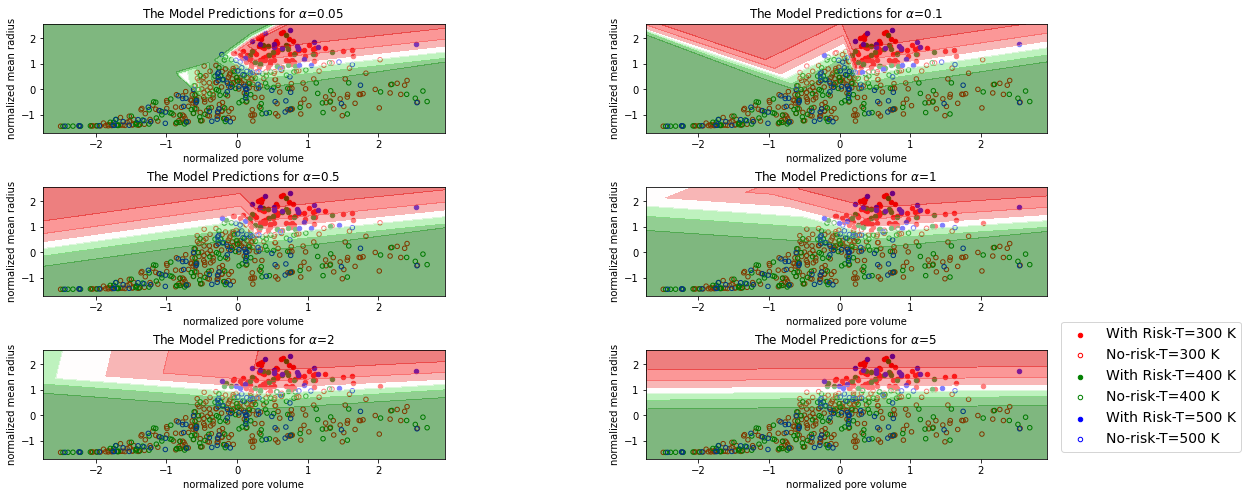

In [67]:
color=["r","g","b"]
label=[300,400,500]
facecolors=['color[j]','none']

index_300=[];index_400=[];index_500=[]

fig, axs = plt.subplots(3, 2,figsize=(18, 8)) #, 
fig.subplots_adjust(wspace=0.5,hspace=0.5)
axs = axs.ravel()

from  matplotlib.colors import LinearSegmentedColormap
cmap_rg=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256)

c = [ "darkgreen","green","palegreen","white","lightcoral","red","darkred"]
v = [0,.15,.4,.5,0.6,.9,1.]
l = list(zip(v,c))
cmap_rg2=LinearSegmentedColormap.from_list('rg',l, N=256)


alpha=[0.05,0.1,0.5,1,2,5] 
counter_tmp=0
for ii in range(len(alpha)):

    name="clf_"+str(counter_tmp)
    print(name)
    name = MLPClassifier(solver='lbfgs', alpha=alpha[ii],hidden_layer_sizes=(10, 2), random_state=1)
    name.fit(x_train_risk2,y_train_risk)
    y_pred_risk=name.predict(x_train_risk2)

    for j in range(3):
        x0_300=[];x1_300=[];y0_300=[];y1_300=[];
        row_num=[]
        counter=0
        for i in range(len(y_train_risk)):
            if (x_train_risk1.iloc[i,-1]==label[j]):
                if (y_pred_risk[i]==0.0):
                    x0_300.append(x_train_risk2[i,0].item())
                    y0_300.append(x_train_risk2[i,1].item())
                elif (y_pred_risk[i]==1.0):
                    x1_300.append(x_train_risk2[i,0].item())
                    y1_300.append(x_train_risk2[i,1].item())
                else:
                    print("Error 300 K")  
        axs[ii].scatter(x1_300, y1_300 , label="With Risk-T="+str(label[j])+" K",color=color[j],s=20 ) #pred_2
        axs[ii].scatter(x0_300, y0_300 , label="No-risk-T="+str(label[j])+" K",color=color[j],facecolor='none',s=20 ) #pred_2


    h = 0.002  # step size in the mesh
    x_min, x_max = x_train_risk2[:,0].min()-0.25 , x_train_risk2[:,0].max()+0.25
    y_min, y_max = x_train_risk2[:,1].min()-0.25 , x_train_risk2[:,1].max()+0.25
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    
    if hasattr(name, "decision_function"):
        Z = name.decision_function(np.column_stack([xx.ravel(), yy.ravel()]))
    else:
        Z = name.predict_proba(np.column_stack([xx.ravel(), yy.ravel()]))[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        axs[ii].contourf(xx, yy, Z, cmap=cmap_rg2, alpha=0.5) #plt.cm.RdBu

    score=name.score(x_train_risk2, y_pred_risk)
    axs[ii].title.set_text("The Model Predictions for "+ r'$\alpha$'+"={} ".format(alpha[ii])) #with a testing score of {} | ,round(score,4)


    
    axs[ii].set_xlabel('normalized pore volume')
    axs[ii].set_ylabel('normalized mean radius')
    counter_tmp+=1

#plt.plot([40,55],[40,55],marker=None,color="green")
#plt.scatter(y_train["elastic_modulous"], y_pred_RF[:,0], c="r", label="Random Forest Regression")
plt.legend(bbox_to_anchor=(1.5 , 0.0), loc="lower right",fontsize = 14)
plt.savefig("../image/mlp-train-regularization", dpi=1200) #facecolor='black',

In [68]:
print(len(y_train_risk))
print(x_test_risk1.shape)

497
(125, 3)


clf_0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


clf_1


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


clf_2


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


clf_3


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


clf_4


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


clf_5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


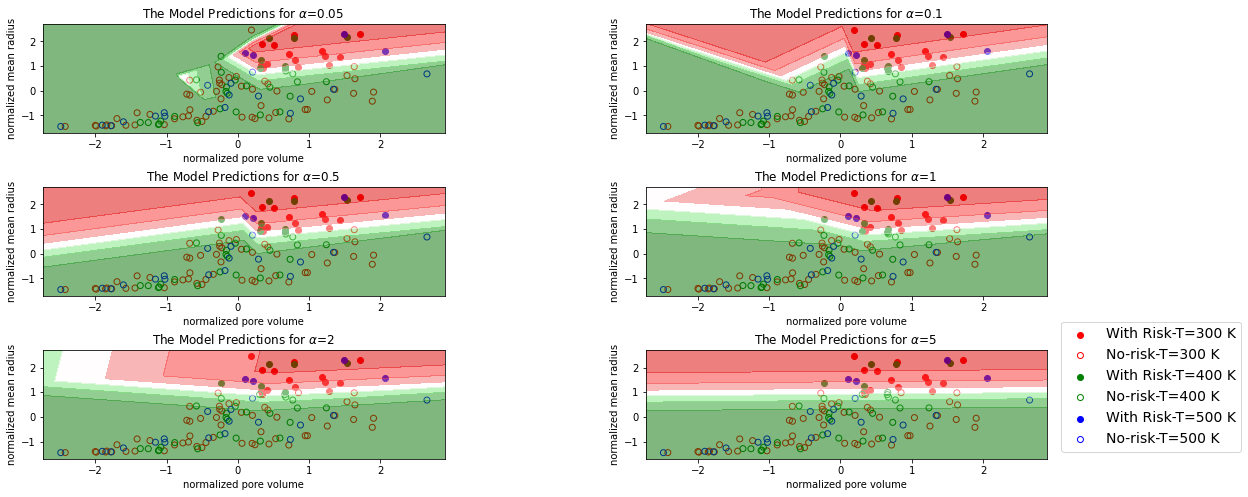

In [69]:
color=["r","g","b"]
label=[300,400,500]
facecolors=['color[j]','none']

index_300=[];index_400=[];index_500=[]

fig, axs = plt.subplots(3, 2,figsize=(18, 8)) #, 
fig.subplots_adjust(wspace=0.5,hspace=0.5)
axs = axs.ravel()
    
alpha=[0.05,0.1,0.5,1,2,5] 
counter_tmp=0
for ii in range(len(alpha)):
    name="clf_"+str(counter_tmp)
    print(name)
    name = MLPClassifier(solver='lbfgs', alpha=alpha[ii],hidden_layer_sizes=(10, 2), random_state=1)
    name.fit(x_train_risk2,y_train_risk)
    y_pred_risk=name.predict(x_test_risk2)

    for j in range(3):
        x0_300=[];x1_300=[];y0_300=[];y1_300=[];
        row_num=[]
        counter=0
        for i in range(len(y_test_risk)):
            if (x_test_risk1.iloc[i,-1]==label[j]):
                if (y_pred_risk[i]==0.0):
                    x0_300.append(x_test_risk2[i,0].item())
                    y0_300.append(x_test_risk2[i,1].item())
                elif (y_pred_risk[i]==1.0):
                    x1_300.append(x_test_risk2[i,0].item())
                    y1_300.append(x_test_risk2[i,1].item())
                else:
                    print("Error 300 K")  
        axs[ii].scatter(x1_300, y1_300 , label="With Risk-T="+str(label[j])+" K",color=color[j] ) #pred_2
        axs[ii].scatter(x0_300, y0_300 , label="No-risk-T="+str(label[j])+" K",color=color[j],facecolor='none' ) #pred_2


    h = 0.002  # step size in the mesh
    x_min, x_max = x_test_risk2[:,0].min()-0.25 , x_test_risk2[:,0].max()+0.25
    y_min, y_max = x_test_risk2[:,1].min()-0.25 , x_test_risk2[:,1].max()+0.25
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    
    if hasattr(name, "decision_function"):
        Z = name.decision_function(np.column_stack([xx.ravel(), yy.ravel()]))
    else:
        Z = name.predict_proba(np.column_stack([xx.ravel(), yy.ravel()]))[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        axs[ii].contourf(xx, yy, Z, cmap=cmap_rg2, alpha=0.5)

    score=name.score(x_test_risk2, y_pred_risk)
    axs[ii].title.set_text("The Model Predictions for "+ r'$\alpha$'+"={} ".format(alpha[ii])) #with a testing score of {} | ,round(score,4)


    
    axs[ii].set_xlabel('normalized pore volume')
    axs[ii].set_ylabel('normalized mean radius')
    counter_tmp+=1
#plt.plot([40,55],[40,55],marker=None,color="green")
#plt.scatter(y_test["elastic_modulous"], y_pred_RF[:,0], c="r", label="Random Forest Regression")
plt.legend(bbox_to_anchor=(1.5 , 0.0), loc="lower right",fontsize = 14)
plt.savefig("../image/mlp-test-regularization", dpi=1200) #facecolor='black',

##  NN modeling with just one output

In [70]:
l1=[col for col in data.columns if col not in prop]
#print(l1)
x_elastic=data.drop(l1,axis=1)
#print(x)
y_elastic=data[["elastic_modulous"]] #[features]

#y=y.reset_index(drop=True)
#print(y)
x_train_elastic, x_test_elastic, y_train_elastic, y_test_elastic = train_test_split(x_elastic, y_elastic, test_size=0.2, random_state=42,stratify=data["T"])
scaler = StandardScaler()
scaler.fit(x_train_elastic)
x_train_elastic = scaler.transform(x_train_elastic)
x_test_elastic = scaler.transform(x_test_elastic)
print(x_test_elastic)

[[-1.39024343 -1.10369004  0.50243191 -1.34490555]
 [-0.03277588  1.43592862 -0.79813402  1.36799936]
 [-0.71150966  1.62332227 -0.79813402 -0.1059227 ]
 [-1.39024343  0.73671061  1.80299784 -0.91476811]
 [-0.71150966 -1.0805519   0.50243191 -1.23319672]
 [-0.03277588  0.44998222  0.50243191  0.14437856]
 [-1.39024343 -1.78029545  1.80299784 -1.41637249]
 [ 0.6459579   0.71449761 -0.79813402  1.49874378]
 [ 1.32469168 -0.15979203  0.50243191  0.14688324]
 [-1.39024343 -1.76943509 -0.79813402 -1.41587155]
 [-0.03277588 -1.4125604  -0.79813402 -0.8927269 ]
 [-1.39024343 -0.50377445 -0.79813402 -1.2452192 ]
 [-1.39024343 -2.48302982  1.80299784 -1.44843242]
 [ 1.32469168 -0.27659301 -0.79813402  0.96491249]
 [-0.03277588  1.22753437 -0.79813402  1.42226748]
 [-0.71150966  0.76987286  0.50243191  0.68455505]
 [-0.71150966  2.05959492  1.80299784  1.59141703]
 [ 1.32469168 -0.23207532  0.50243191  0.74700513]
 [ 1.32469168  0.0990013   1.80299784  1.52278873]
 [-1.39024343  1.88551027 -0.79

In [71]:
#Create the layers
n1=10 #neuron
n2=20 #neuron
n_input=x_elastic.shape[1]
n_output=y_elastic.shape[1]
input_layer=Input(shape=(n_input,),name='input_layer')
layer_1=Dense(n1,activation="linear",name='layer_1')(input_layer)
layer_2=Dense(n2,activation="linear",name='layer_2')(layer_1)
layer_3=Dense(n2,activation="linear",name='layer_3')(layer_2)


#1st output
y1_output=Dense(n_output,activation="linear",name='y1_output')(layer_3)


#Define the model
model_nn_elastic=Model(inputs=input_layer,outputs=y1_output)#[,y3_output]

#MSummary of Model
model_nn_elastic.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 4)]               0         
                                                                 
 layer_1 (Dense)             (None, 10)                50        
                                                                 
 layer_2 (Dense)             (None, 20)                220       
                                                                 
 layer_3 (Dense)             (None, 20)                420       
                                                                 
 y1_output (Dense)           (None, 1)                 21        
                                                                 
Total params: 711
Trainable params: 711
Non-trainable params: 0
_________________________________________________________________


In [72]:
## defining the optimiser and loss function
model_nn_elastic.compile(optimizer='adam', loss='mse') #,'y3_output':'mse'

##train the model
history=model_nn_elastic.fit(x_train_elastic,y_train_elastic,epochs=1000, batch_size=128, validation_data=(x_test_elastic,y_test_elastic))

Epoch 1/1000
4/4 [==============================] - 4s 181ms/step - loss: 2363.0098 - val_loss: 2354.6680
Epoch 2/1000
4/4 [==============================] - 0s 23ms/step - loss: 2358.2515 - val_loss: 2349.3877
Epoch 3/1000
4/4 [==============================] - 0s 20ms/step - loss: 2353.5564 - val_loss: 2344.3105
Epoch 4/1000
4/4 [==============================] - 0s 28ms/step - loss: 2348.6990 - val_loss: 2339.0454
Epoch 5/1000
4/4 [==============================] - 0s 30ms/step - loss: 2343.5786 - val_loss: 2333.5811
Epoch 6/1000
4/4 [==============================] - 0s 25ms/step - loss: 2338.1877 - val_loss: 2327.4429
Epoch 7/1000
4/4 [==============================] - 0s 31ms/step - loss: 2332.1321 - val_loss: 2320.8357
Epoch 8/1000
4/4 [==============================] - 0s 47ms/step - loss: 2325.4009 - val_loss: 2313.3186
Epoch 9/1000
4/4 [==============================] - 0s 26ms/step - loss: 2317.8088 - val_loss: 2304.7017
Epoch 10/1000
4/4 [==============================] - 0

4/4 [==============================] - 0s 19ms/step - loss: 0.5622 - val_loss: 0.5485
Epoch 81/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.5618 - val_loss: 0.5480
Epoch 82/1000
4/4 [==============================] - 0s 20ms/step - loss: 0.5615 - val_loss: 0.5443
Epoch 83/1000
4/4 [==============================] - 0s 19ms/step - loss: 0.5611 - val_loss: 0.5443
Epoch 84/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.5619 - val_loss: 0.5459
Epoch 85/1000
4/4 [==============================] - 0s 19ms/step - loss: 0.5616 - val_loss: 0.5453
Epoch 86/1000
4/4 [==============================] - 0s 19ms/step - loss: 0.5621 - val_loss: 0.5473
Epoch 87/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.5616 - val_loss: 0.5471
Epoch 88/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.5617 - val_loss: 0.5463
Epoch 89/1000
4/4 [==============================] - 0s 20ms/step - loss: 0.5617 - val_loss: 0.5448
Epoch 90/1000


4/4 [==============================] - 0s 25ms/step - loss: 0.5617 - val_loss: 0.5461
Epoch 162/1000
4/4 [==============================] - 0s 36ms/step - loss: 0.5616 - val_loss: 0.5452
Epoch 163/1000
4/4 [==============================] - 0s 28ms/step - loss: 0.5664 - val_loss: 0.5492
Epoch 164/1000
4/4 [==============================] - 0s 24ms/step - loss: 0.5674 - val_loss: 0.5549
Epoch 165/1000
4/4 [==============================] - 0s 29ms/step - loss: 0.5632 - val_loss: 0.5537
Epoch 166/1000
4/4 [==============================] - 0s 27ms/step - loss: 0.5620 - val_loss: 0.5440
Epoch 167/1000
4/4 [==============================] - 0s 27ms/step - loss: 0.5625 - val_loss: 0.5409
Epoch 168/1000
4/4 [==============================] - 0s 26ms/step - loss: 0.5621 - val_loss: 0.5449
Epoch 169/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.5612 - val_loss: 0.5493
Epoch 170/1000
4/4 [==============================] - 0s 21ms/step - loss: 0.5622 - val_loss: 0.5515
Epoch

4/4 [==============================] - 0s 21ms/step - loss: 0.5627 - val_loss: 0.5504
Epoch 243/1000
4/4 [==============================] - 0s 21ms/step - loss: 0.5630 - val_loss: 0.5499
Epoch 244/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.5623 - val_loss: 0.5506
Epoch 245/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.5632 - val_loss: 0.5435
Epoch 246/1000
4/4 [==============================] - 0s 43ms/step - loss: 0.5616 - val_loss: 0.5420
Epoch 247/1000
4/4 [==============================] - 0s 40ms/step - loss: 0.5632 - val_loss: 0.5459
Epoch 248/1000
4/4 [==============================] - 0s 32ms/step - loss: 0.5633 - val_loss: 0.5434
Epoch 249/1000
4/4 [==============================] - 0s 31ms/step - loss: 0.5618 - val_loss: 0.5474
Epoch 250/1000
4/4 [==============================] - 0s 32ms/step - loss: 0.5622 - val_loss: 0.5505
Epoch 251/1000
4/4 [==============================] - 0s 35ms/step - loss: 0.5634 - val_loss: 0.5530
Epoch

4/4 [==============================] - 0s 78ms/step - loss: 0.5629 - val_loss: 0.5495
Epoch 324/1000
4/4 [==============================] - 0s 51ms/step - loss: 0.5622 - val_loss: 0.5490
Epoch 325/1000
4/4 [==============================] - 0s 119ms/step - loss: 0.5631 - val_loss: 0.5426
Epoch 326/1000
4/4 [==============================] - 0s 97ms/step - loss: 0.5614 - val_loss: 0.5477
Epoch 327/1000
4/4 [==============================] - 0s 41ms/step - loss: 0.5624 - val_loss: 0.5506
Epoch 328/1000
4/4 [==============================] - 0s 41ms/step - loss: 0.5642 - val_loss: 0.5460
Epoch 329/1000
4/4 [==============================] - 0s 34ms/step - loss: 0.5635 - val_loss: 0.5445
Epoch 330/1000
4/4 [==============================] - 0s 77ms/step - loss: 0.5633 - val_loss: 0.5454
Epoch 331/1000
4/4 [==============================] - 0s 58ms/step - loss: 0.5615 - val_loss: 0.5441
Epoch 332/1000
4/4 [==============================] - 0s 76ms/step - loss: 0.5630 - val_loss: 0.5481
Epoc

4/4 [==============================] - 0s 32ms/step - loss: 0.5663 - val_loss: 0.5447
Epoch 405/1000
4/4 [==============================] - 0s 109ms/step - loss: 0.5630 - val_loss: 0.5521
Epoch 406/1000
4/4 [==============================] - 0s 94ms/step - loss: 0.5703 - val_loss: 0.5581
Epoch 407/1000
4/4 [==============================] - 0s 83ms/step - loss: 0.5641 - val_loss: 0.5414
Epoch 408/1000
4/4 [==============================] - 1s 290ms/step - loss: 0.5691 - val_loss: 0.5480
Epoch 409/1000
4/4 [==============================] - 0s 85ms/step - loss: 0.5671 - val_loss: 0.5503
Epoch 410/1000
4/4 [==============================] - 0s 140ms/step - loss: 0.5651 - val_loss: 0.5521
Epoch 411/1000
4/4 [==============================] - 0s 68ms/step - loss: 0.5630 - val_loss: 0.5438
Epoch 412/1000
4/4 [==============================] - 0s 34ms/step - loss: 0.5630 - val_loss: 0.5426
Epoch 413/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.5630 - val_loss: 0.5452
Ep

4/4 [==============================] - 0s 39ms/step - loss: 0.5652 - val_loss: 0.5401
Epoch 486/1000
4/4 [==============================] - 0s 37ms/step - loss: 0.5653 - val_loss: 0.5397
Epoch 487/1000
4/4 [==============================] - 0s 30ms/step - loss: 0.5609 - val_loss: 0.5536
Epoch 488/1000
4/4 [==============================] - 0s 26ms/step - loss: 0.5717 - val_loss: 0.5593
Epoch 489/1000
4/4 [==============================] - 0s 24ms/step - loss: 0.5627 - val_loss: 0.5477
Epoch 490/1000
4/4 [==============================] - 0s 28ms/step - loss: 0.5693 - val_loss: 0.5434
Epoch 491/1000
4/4 [==============================] - 0s 37ms/step - loss: 0.5611 - val_loss: 0.5640
Epoch 492/1000
4/4 [==============================] - 0s 55ms/step - loss: 0.5680 - val_loss: 0.5495
Epoch 493/1000
4/4 [==============================] - 0s 26ms/step - loss: 0.5639 - val_loss: 0.5458
Epoch 494/1000
4/4 [==============================] - 0s 28ms/step - loss: 0.5628 - val_loss: 0.5474
Epoch

4/4 [==============================] - 0s 19ms/step - loss: 0.5658 - val_loss: 0.5430
Epoch 567/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.5655 - val_loss: 0.5619
Epoch 568/1000
4/4 [==============================] - 0s 25ms/step - loss: 0.5653 - val_loss: 0.5505
Epoch 569/1000
4/4 [==============================] - 0s 30ms/step - loss: 0.5657 - val_loss: 0.5442
Epoch 570/1000
4/4 [==============================] - 0s 27ms/step - loss: 0.5684 - val_loss: 0.5514
Epoch 571/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.5634 - val_loss: 0.5513
Epoch 572/1000
4/4 [==============================] - 0s 52ms/step - loss: 0.5663 - val_loss: 0.5484
Epoch 573/1000
4/4 [==============================] - 0s 56ms/step - loss: 0.5649 - val_loss: 0.5476
Epoch 574/1000
4/4 [==============================] - 0s 64ms/step - loss: 0.5632 - val_loss: 0.5471
Epoch 575/1000
4/4 [==============================] - 0s 61ms/step - loss: 0.5674 - val_loss: 0.5490
Epoch

4/4 [==============================] - 0s 104ms/step - loss: 0.5701 - val_loss: 0.5643
Epoch 648/1000
4/4 [==============================] - 0s 103ms/step - loss: 0.5703 - val_loss: 0.5400
Epoch 649/1000
4/4 [==============================] - 0s 75ms/step - loss: 0.5650 - val_loss: 0.5400
Epoch 650/1000
4/4 [==============================] - 0s 72ms/step - loss: 0.5688 - val_loss: 0.5579
Epoch 651/1000
4/4 [==============================] - 0s 54ms/step - loss: 0.5647 - val_loss: 0.5553
Epoch 652/1000
4/4 [==============================] - 0s 41ms/step - loss: 0.5632 - val_loss: 0.5385
Epoch 653/1000
4/4 [==============================] - 0s 53ms/step - loss: 0.5706 - val_loss: 0.5427
Epoch 654/1000
4/4 [==============================] - 0s 72ms/step - loss: 0.5647 - val_loss: 0.5540
Epoch 655/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.5656 - val_loss: 0.5479
Epoch 656/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.5695 - val_loss: 0.5504
Epo

4/4 [==============================] - 0s 21ms/step - loss: 0.5712 - val_loss: 0.5416
Epoch 729/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.5795 - val_loss: 0.5723
Epoch 730/1000
4/4 [==============================] - 0s 26ms/step - loss: 0.5627 - val_loss: 0.5472
Epoch 731/1000
4/4 [==============================] - 0s 21ms/step - loss: 0.5679 - val_loss: 0.5394
Epoch 732/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.5756 - val_loss: 0.5463
Epoch 733/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.5627 - val_loss: 0.5487
Epoch 734/1000
4/4 [==============================] - 0s 29ms/step - loss: 0.5684 - val_loss: 0.5631
Epoch 735/1000
4/4 [==============================] - 0s 76ms/step - loss: 0.5635 - val_loss: 0.5499
Epoch 736/1000
4/4 [==============================] - 0s 46ms/step - loss: 0.5700 - val_loss: 0.5418
Epoch 737/1000
4/4 [==============================] - 0s 39ms/step - loss: 0.5623 - val_loss: 0.5522
Epoch

4/4 [==============================] - 0s 55ms/step - loss: 0.5812 - val_loss: 0.5476
Epoch 810/1000
4/4 [==============================] - 0s 35ms/step - loss: 0.5771 - val_loss: 0.5678
Epoch 811/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.5701 - val_loss: 0.5658
Epoch 812/1000
4/4 [==============================] - 0s 26ms/step - loss: 0.5737 - val_loss: 0.5365
Epoch 813/1000
4/4 [==============================] - 0s 51ms/step - loss: 0.5659 - val_loss: 0.5480
Epoch 814/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.5625 - val_loss: 0.5649
Epoch 815/1000
4/4 [==============================] - 0s 21ms/step - loss: 0.5643 - val_loss: 0.5517
Epoch 816/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.5645 - val_loss: 0.5381
Epoch 817/1000
4/4 [==============================] - 0s 25ms/step - loss: 0.5770 - val_loss: 0.5439
Epoch 818/1000
4/4 [==============================] - 0s 19ms/step - loss: 0.5710 - val_loss: 0.5705
Epoch

4/4 [==============================] - 0s 18ms/step - loss: 0.5710 - val_loss: 0.5389
Epoch 891/1000
4/4 [==============================] - 0s 19ms/step - loss: 0.5666 - val_loss: 0.5564
Epoch 892/1000
4/4 [==============================] - 0s 20ms/step - loss: 0.5803 - val_loss: 0.5595
Epoch 893/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.5746 - val_loss: 0.5402
Epoch 894/1000
4/4 [==============================] - 0s 19ms/step - loss: 0.5642 - val_loss: 0.5615
Epoch 895/1000
4/4 [==============================] - 0s 20ms/step - loss: 0.5667 - val_loss: 0.5484
Epoch 896/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.5774 - val_loss: 0.5510
Epoch 897/1000
4/4 [==============================] - 0s 20ms/step - loss: 0.5643 - val_loss: 0.5488
Epoch 898/1000
4/4 [==============================] - 0s 19ms/step - loss: 0.5687 - val_loss: 0.5472
Epoch 899/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.5700 - val_loss: 0.5549
Epoch

4/4 [==============================] - 0s 33ms/step - loss: 0.5744 - val_loss: 0.5646
Epoch 972/1000
4/4 [==============================] - 0s 35ms/step - loss: 0.5812 - val_loss: 0.5333
Epoch 973/1000
4/4 [==============================] - 0s 54ms/step - loss: 0.5699 - val_loss: 0.5666
Epoch 974/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.5693 - val_loss: 0.5531
Epoch 975/1000
4/4 [==============================] - 0s 57ms/step - loss: 0.5676 - val_loss: 0.5453
Epoch 976/1000
4/4 [==============================] - 0s 19ms/step - loss: 0.5672 - val_loss: 0.5400
Epoch 977/1000
4/4 [==============================] - 0s 20ms/step - loss: 0.5677 - val_loss: 0.5496
Epoch 978/1000
4/4 [==============================] - 0s 20ms/step - loss: 0.5628 - val_loss: 0.5489
Epoch 979/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.5674 - val_loss: 0.5484
Epoch 980/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.5783 - val_loss: 0.5431
Epoch

4/4 [==============================] - 0s 7ms/step - loss: 0.5310


Text(0.5, 0, 'epochs')

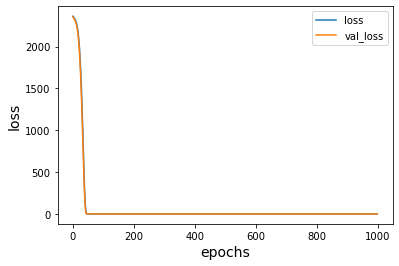

In [73]:
# Evalute the Model
model_nn_elastic.evaluate(x_test_elastic, y_test_elastic)

# Plot loss VS epochs graph
pd.DataFrame(history.history).plot()
plt.ylabel('loss', fontsize=14)
plt.xlabel('epochs', fontsize=14)

In [74]:
predictions_elastic = model_nn_elastic .predict(x_test_elastic)
pred_1_elastic =predictions_elastic [:,0]

4/4 [==============================] - 4s 6ms/step


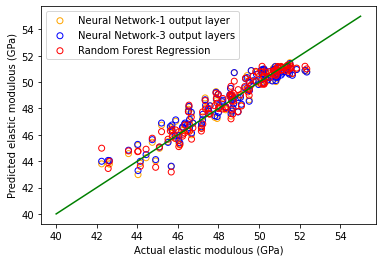

In [75]:
plt.scatter(y_test_elastic["elastic_modulous"],pred_1_elastic,label="Neural Network-1 output layer" , color="orange",facecolors='none') #pred_2
plt.scatter(y_test["elastic_modulous"],pred_1,label="Neural Network-3 output layers",facecolors='none',color="blue" ) #pred_2

plt.xlabel('Actual elastic modulous (GPa)')
plt.ylabel('Predicted elastic modulous (GPa)')
plt.plot([40,55],[40,55],marker=None,color="green")
plt.scatter(y_test["elastic_modulous"], y_pred_RF[:,0], color="r", label="Random Forest Regression",facecolors='none')
plt.legend()

In [76]:
nn_results_elastic = model_nn_elastic.predict(x_test_elastic)
r2score_nn_elastic = r2_score(y_test_elastic, nn_results_elastic) 
MSE_nn_elastic = mean_squared_error(y_test_elastic, nn_results_elastic)
MAE_nn_elastic = mean_absolute_error(y_test_elastic, nn_results_elastic)
print(r2score_nn_elastic,MSE_nn_elastic,MAE_nn_elastic)

4/4 [==============================] - 0s 6ms/step
0.9016289585585557 0.5309871389639055 0.5684991792738769


# Yield Stress

In [77]:
l1=[col for col in data.columns if col not in prop]
#print(l1)
x_stress=data.drop(l1,axis=1)
#print(x)
y_stress=data[["stress_yield"]] #[features]

#y=y.reset_index(drop=True)
#print(y)
x_train_stress, x_test_stress, y_train_stress, y_test_stress = train_test_split(x_stress, y_stress, test_size=0.2, random_state=42,stratify=data["T"])
scaler = StandardScaler()
scaler.fit(x_train_stress)
x_train_stress = scaler.transform(x_train_stress)
x_test_stress = scaler.transform(x_test_stress)
print(x_test_stress)

[[-1.39024343 -1.10369004  0.50243191 -1.34490555]
 [-0.03277588  1.43592862 -0.79813402  1.36799936]
 [-0.71150966  1.62332227 -0.79813402 -0.1059227 ]
 [-1.39024343  0.73671061  1.80299784 -0.91476811]
 [-0.71150966 -1.0805519   0.50243191 -1.23319672]
 [-0.03277588  0.44998222  0.50243191  0.14437856]
 [-1.39024343 -1.78029545  1.80299784 -1.41637249]
 [ 0.6459579   0.71449761 -0.79813402  1.49874378]
 [ 1.32469168 -0.15979203  0.50243191  0.14688324]
 [-1.39024343 -1.76943509 -0.79813402 -1.41587155]
 [-0.03277588 -1.4125604  -0.79813402 -0.8927269 ]
 [-1.39024343 -0.50377445 -0.79813402 -1.2452192 ]
 [-1.39024343 -2.48302982  1.80299784 -1.44843242]
 [ 1.32469168 -0.27659301 -0.79813402  0.96491249]
 [-0.03277588  1.22753437 -0.79813402  1.42226748]
 [-0.71150966  0.76987286  0.50243191  0.68455505]
 [-0.71150966  2.05959492  1.80299784  1.59141703]
 [ 1.32469168 -0.23207532  0.50243191  0.74700513]
 [ 1.32469168  0.0990013   1.80299784  1.52278873]
 [-1.39024343  1.88551027 -0.79

In [78]:
#Create the layers
n1=10 #neuron
n2=20 #neuron
n_input=x_stress.shape[1]
n_output=y_stress.shape[1]
input_layer=Input(shape=(n_input,),name='input_layer')
layer_1=Dense(n1,activation="linear",name='layer_1')(input_layer)
layer_2=Dense(n2,activation="linear",name='layer_2')(layer_1)
layer_3=Dense(n2,activation="linear",name='layer_3')(layer_2)


#1st output
y1_output=Dense(n_output,activation="linear",name='y1_output')(layer_3)


#Define the model
model_nn_stress=Model(inputs=input_layer,outputs=y1_output)#[,y3_output]

#MSummary of Model
model_nn_stress.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 4)]               0         
                                                                 
 layer_1 (Dense)             (None, 10)                50        
                                                                 
 layer_2 (Dense)             (None, 20)                220       
                                                                 
 layer_3 (Dense)             (None, 20)                420       
                                                                 
 y1_output (Dense)           (None, 1)                 21        
                                                                 
Total params: 711
Trainable params: 711
Non-trainable params: 0
_________________________________________________________________


In [79]:
## defining the optimiser and loss function
model_nn_stress.compile(optimizer='adam', loss='mse') #,'y3_output':'mse'

##train the model
history=model_nn_stress.fit(x_train_stress,y_train_stress,epochs=1000, batch_size=128, validation_data=(x_test_stress,y_test_stress))

Epoch 1/1000
4/4 [==============================] - 5s 488ms/step - loss: 22.9647 - val_loss: 23.1051
Epoch 2/1000
4/4 [==============================] - 0s 33ms/step - loss: 22.0591 - val_loss: 22.1931
Epoch 3/1000
4/4 [==============================] - 0s 42ms/step - loss: 21.1951 - val_loss: 21.4574
Epoch 4/1000
4/4 [==============================] - 0s 63ms/step - loss: 20.5176 - val_loss: 20.8143
Epoch 5/1000
4/4 [==============================] - 0s 40ms/step - loss: 19.9264 - val_loss: 20.2224
Epoch 6/1000
4/4 [==============================] - 0s 25ms/step - loss: 19.3830 - val_loss: 19.6477
Epoch 7/1000
4/4 [==============================] - 0s 22ms/step - loss: 18.8271 - val_loss: 19.0607
Epoch 8/1000
4/4 [==============================] - 0s 22ms/step - loss: 18.2607 - val_loss: 18.4344
Epoch 9/1000
4/4 [==============================] - 0s 21ms/step - loss: 17.6507 - val_loss: 17.7662
Epoch 10/1000
4/4 [==============================] - 0s 30ms/step - loss: 16.9667 - val_lo

4/4 [==============================] - 0s 24ms/step - loss: 0.0780 - val_loss: 0.0560
Epoch 83/1000
4/4 [==============================] - 0s 29ms/step - loss: 0.0778 - val_loss: 0.0547
Epoch 84/1000
4/4 [==============================] - 0s 25ms/step - loss: 0.0777 - val_loss: 0.0544
Epoch 85/1000
4/4 [==============================] - 0s 21ms/step - loss: 0.0776 - val_loss: 0.0542
Epoch 86/1000
4/4 [==============================] - 0s 32ms/step - loss: 0.0775 - val_loss: 0.0552
Epoch 87/1000
4/4 [==============================] - 0s 20ms/step - loss: 0.0775 - val_loss: 0.0543
Epoch 88/1000
4/4 [==============================] - 0s 19ms/step - loss: 0.0773 - val_loss: 0.0542
Epoch 89/1000
4/4 [==============================] - 0s 21ms/step - loss: 0.0774 - val_loss: 0.0546
Epoch 90/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.0774 - val_loss: 0.0550
Epoch 91/1000
4/4 [==============================] - 0s 21ms/step - loss: 0.0773 - val_loss: 0.0550
Epoch 92/1000


4/4 [==============================] - 0s 50ms/step - loss: 0.0773 - val_loss: 0.0538
Epoch 164/1000
4/4 [==============================] - 0s 38ms/step - loss: 0.0775 - val_loss: 0.0541
Epoch 165/1000
4/4 [==============================] - 0s 52ms/step - loss: 0.0777 - val_loss: 0.0549
Epoch 166/1000
4/4 [==============================] - 0s 36ms/step - loss: 0.0774 - val_loss: 0.0541
Epoch 167/1000
4/4 [==============================] - 0s 51ms/step - loss: 0.0776 - val_loss: 0.0549
Epoch 168/1000
4/4 [==============================] - 0s 48ms/step - loss: 0.0779 - val_loss: 0.0548
Epoch 169/1000
4/4 [==============================] - 0s 43ms/step - loss: 0.0774 - val_loss: 0.0546
Epoch 170/1000
4/4 [==============================] - 0s 54ms/step - loss: 0.0775 - val_loss: 0.0544
Epoch 171/1000
4/4 [==============================] - 0s 39ms/step - loss: 0.0775 - val_loss: 0.0543
Epoch 172/1000
4/4 [==============================] - 0s 45ms/step - loss: 0.0777 - val_loss: 0.0553
Epoch

4/4 [==============================] - 0s 27ms/step - loss: 0.0778 - val_loss: 0.0545
Epoch 245/1000
4/4 [==============================] - 0s 28ms/step - loss: 0.0791 - val_loss: 0.0568
Epoch 246/1000
4/4 [==============================] - 0s 35ms/step - loss: 0.0776 - val_loss: 0.0530
Epoch 247/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.0780 - val_loss: 0.0537
Epoch 248/1000
4/4 [==============================] - 0s 20ms/step - loss: 0.0781 - val_loss: 0.0577
Epoch 249/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.0787 - val_loss: 0.0545
Epoch 250/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.0776 - val_loss: 0.0551
Epoch 251/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0777 - val_loss: 0.0556
Epoch 252/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.0777 - val_loss: 0.0546
Epoch 253/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.0777 - val_loss: 0.0538
Epoch

4/4 [==============================] - 0s 31ms/step - loss: 0.0778 - val_loss: 0.0544
Epoch 326/1000
4/4 [==============================] - 0s 24ms/step - loss: 0.0780 - val_loss: 0.0540
Epoch 327/1000
4/4 [==============================] - 0s 20ms/step - loss: 0.0776 - val_loss: 0.0552
Epoch 328/1000
4/4 [==============================] - 0s 20ms/step - loss: 0.0779 - val_loss: 0.0538
Epoch 329/1000
4/4 [==============================] - 0s 20ms/step - loss: 0.0777 - val_loss: 0.0545
Epoch 330/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.0776 - val_loss: 0.0558
Epoch 331/1000
4/4 [==============================] - 0s 33ms/step - loss: 0.0776 - val_loss: 0.0549
Epoch 332/1000
4/4 [==============================] - 0s 47ms/step - loss: 0.0780 - val_loss: 0.0536
Epoch 333/1000
4/4 [==============================] - 0s 51ms/step - loss: 0.0773 - val_loss: 0.0563
Epoch 334/1000
4/4 [==============================] - 0s 49ms/step - loss: 0.0783 - val_loss: 0.0545
Epoch

4/4 [==============================] - 0s 21ms/step - loss: 0.0779 - val_loss: 0.0551
Epoch 407/1000
4/4 [==============================] - 0s 21ms/step - loss: 0.0777 - val_loss: 0.0544
Epoch 408/1000
4/4 [==============================] - 0s 21ms/step - loss: 0.0776 - val_loss: 0.0549
Epoch 409/1000
4/4 [==============================] - 0s 20ms/step - loss: 0.0776 - val_loss: 0.0546
Epoch 410/1000
4/4 [==============================] - 0s 21ms/step - loss: 0.0776 - val_loss: 0.0546
Epoch 411/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.0776 - val_loss: 0.0532
Epoch 412/1000
4/4 [==============================] - 0s 21ms/step - loss: 0.0777 - val_loss: 0.0544
Epoch 413/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.0782 - val_loss: 0.0581
Epoch 414/1000
4/4 [==============================] - 0s 20ms/step - loss: 0.0779 - val_loss: 0.0532
Epoch 415/1000
4/4 [==============================] - 0s 20ms/step - loss: 0.0783 - val_loss: 0.0534
Epoch

4/4 [==============================] - 0s 75ms/step - loss: 0.0776 - val_loss: 0.0536
Epoch 488/1000
4/4 [==============================] - 0s 19ms/step - loss: 0.0779 - val_loss: 0.0555
Epoch 489/1000
4/4 [==============================] - 0s 22ms/step - loss: 0.0778 - val_loss: 0.0550
Epoch 490/1000
4/4 [==============================] - 0s 28ms/step - loss: 0.0777 - val_loss: 0.0538
Epoch 491/1000
4/4 [==============================] - 0s 26ms/step - loss: 0.0780 - val_loss: 0.0561
Epoch 492/1000
4/4 [==============================] - 0s 31ms/step - loss: 0.0778 - val_loss: 0.0547
Epoch 493/1000
4/4 [==============================] - 0s 21ms/step - loss: 0.0777 - val_loss: 0.0537
Epoch 494/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0781 - val_loss: 0.0560
Epoch 495/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.0780 - val_loss: 0.0550
Epoch 496/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.0775 - val_loss: 0.0541
Epoch

4/4 [==============================] - 0s 27ms/step - loss: 0.0777 - val_loss: 0.0530
Epoch 569/1000
4/4 [==============================] - 0s 30ms/step - loss: 0.0778 - val_loss: 0.0547
Epoch 570/1000
4/4 [==============================] - 0s 38ms/step - loss: 0.0787 - val_loss: 0.0578
Epoch 571/1000
4/4 [==============================] - 0s 30ms/step - loss: 0.0784 - val_loss: 0.0530
Epoch 572/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.0776 - val_loss: 0.0556
Epoch 573/1000
4/4 [==============================] - 0s 28ms/step - loss: 0.0781 - val_loss: 0.0559
Epoch 574/1000
4/4 [==============================] - 0s 25ms/step - loss: 0.0787 - val_loss: 0.0532
Epoch 575/1000
4/4 [==============================] - 0s 24ms/step - loss: 0.0779 - val_loss: 0.0565
Epoch 576/1000
4/4 [==============================] - 0s 24ms/step - loss: 0.0786 - val_loss: 0.0549
Epoch 577/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.0777 - val_loss: 0.0539
Epoch

4/4 [==============================] - 0s 23ms/step - loss: 0.0782 - val_loss: 0.0560
Epoch 650/1000
4/4 [==============================] - 0s 41ms/step - loss: 0.0775 - val_loss: 0.0541
Epoch 651/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.0779 - val_loss: 0.0539
Epoch 652/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0782 - val_loss: 0.0562
Epoch 653/1000
4/4 [==============================] - 0s 41ms/step - loss: 0.0788 - val_loss: 0.0555
Epoch 654/1000
4/4 [==============================] - 0s 31ms/step - loss: 0.0778 - val_loss: 0.0549
Epoch 655/1000
4/4 [==============================] - 0s 51ms/step - loss: 0.0776 - val_loss: 0.0538
Epoch 656/1000
4/4 [==============================] - 0s 27ms/step - loss: 0.0785 - val_loss: 0.0551
Epoch 657/1000
4/4 [==============================] - 0s 31ms/step - loss: 0.0778 - val_loss: 0.0534
Epoch 658/1000
4/4 [==============================] - 0s 29ms/step - loss: 0.0786 - val_loss: 0.0557
Epoch

4/4 [==============================] - 0s 55ms/step - loss: 0.0785 - val_loss: 0.0595
Epoch 731/1000
4/4 [==============================] - 0s 67ms/step - loss: 0.0783 - val_loss: 0.0534
Epoch 732/1000
4/4 [==============================] - 0s 40ms/step - loss: 0.0790 - val_loss: 0.0534
Epoch 733/1000
4/4 [==============================] - 0s 35ms/step - loss: 0.0787 - val_loss: 0.0584
Epoch 734/1000
4/4 [==============================] - 0s 44ms/step - loss: 0.0778 - val_loss: 0.0524
Epoch 735/1000
4/4 [==============================] - 0s 31ms/step - loss: 0.0785 - val_loss: 0.0552
Epoch 736/1000
4/4 [==============================] - 0s 37ms/step - loss: 0.0785 - val_loss: 0.0549
Epoch 737/1000
4/4 [==============================] - 0s 34ms/step - loss: 0.0800 - val_loss: 0.0532
Epoch 738/1000
4/4 [==============================] - 0s 28ms/step - loss: 0.0775 - val_loss: 0.0609
Epoch 739/1000
4/4 [==============================] - 0s 30ms/step - loss: 0.0792 - val_loss: 0.0527
Epoch

4/4 [==============================] - 0s 27ms/step - loss: 0.0780 - val_loss: 0.0573
Epoch 812/1000
4/4 [==============================] - 0s 33ms/step - loss: 0.0781 - val_loss: 0.0544
Epoch 813/1000
4/4 [==============================] - 0s 40ms/step - loss: 0.0779 - val_loss: 0.0535
Epoch 814/1000
4/4 [==============================] - 0s 27ms/step - loss: 0.0783 - val_loss: 0.0550
Epoch 815/1000
4/4 [==============================] - 0s 32ms/step - loss: 0.0777 - val_loss: 0.0550
Epoch 816/1000
4/4 [==============================] - 0s 30ms/step - loss: 0.0775 - val_loss: 0.0555
Epoch 817/1000
4/4 [==============================] - 0s 26ms/step - loss: 0.0775 - val_loss: 0.0541
Epoch 818/1000
4/4 [==============================] - 0s 25ms/step - loss: 0.0777 - val_loss: 0.0542
Epoch 819/1000
4/4 [==============================] - 0s 29ms/step - loss: 0.0779 - val_loss: 0.0547
Epoch 820/1000
4/4 [==============================] - 0s 37ms/step - loss: 0.0790 - val_loss: 0.0555
Epoch

4/4 [==============================] - 0s 34ms/step - loss: 0.0787 - val_loss: 0.0534
Epoch 893/1000
4/4 [==============================] - 0s 38ms/step - loss: 0.0788 - val_loss: 0.0536
Epoch 894/1000
4/4 [==============================] - 0s 24ms/step - loss: 0.0785 - val_loss: 0.0571
Epoch 895/1000
4/4 [==============================] - 0s 30ms/step - loss: 0.0776 - val_loss: 0.0538
Epoch 896/1000
4/4 [==============================] - 0s 45ms/step - loss: 0.0781 - val_loss: 0.0537
Epoch 897/1000
4/4 [==============================] - 0s 45ms/step - loss: 0.0781 - val_loss: 0.0542
Epoch 898/1000
4/4 [==============================] - 0s 38ms/step - loss: 0.0777 - val_loss: 0.0573
Epoch 899/1000
4/4 [==============================] - 0s 32ms/step - loss: 0.0781 - val_loss: 0.0547
Epoch 900/1000
4/4 [==============================] - 0s 39ms/step - loss: 0.0781 - val_loss: 0.0541
Epoch 901/1000
4/4 [==============================] - 0s 26ms/step - loss: 0.0777 - val_loss: 0.0553
Epoch

4/4 [==============================] - 0s 33ms/step - loss: 0.0794 - val_loss: 0.0561
Epoch 974/1000
4/4 [==============================] - 0s 50ms/step - loss: 0.0787 - val_loss: 0.0555
Epoch 975/1000
4/4 [==============================] - 0s 25ms/step - loss: 0.0808 - val_loss: 0.0526
Epoch 976/1000
4/4 [==============================] - 0s 25ms/step - loss: 0.0771 - val_loss: 0.0600
Epoch 977/1000
4/4 [==============================] - 0s 27ms/step - loss: 0.0799 - val_loss: 0.0560
Epoch 978/1000
4/4 [==============================] - 0s 27ms/step - loss: 0.0796 - val_loss: 0.0543
Epoch 979/1000
4/4 [==============================] - 0s 26ms/step - loss: 0.0794 - val_loss: 0.0583
Epoch 980/1000
4/4 [==============================] - 0s 32ms/step - loss: 0.0792 - val_loss: 0.0533
Epoch 981/1000
4/4 [==============================] - 0s 23ms/step - loss: 0.0780 - val_loss: 0.0569
Epoch 982/1000
4/4 [==============================] - 0s 24ms/step - loss: 0.0786 - val_loss: 0.0547
Epoch

4/4 [==============================] - 0s 5ms/step - loss: 0.0539


Text(0.5, 0, 'epochs')

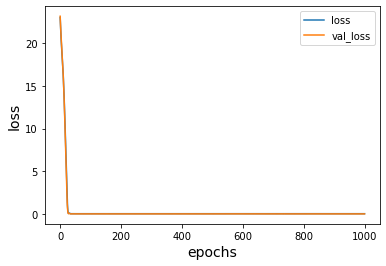

In [80]:
# Evalute the Model
model_nn_stress.evaluate(x_test_stress, y_test_stress)

# Plot loss VS epochs graph
pd.DataFrame(history.history).plot()
plt.ylabel('loss', fontsize=14)
plt.xlabel('epochs', fontsize=14)

In [81]:
predictions_stress = model_nn_stress .predict(x_test_stress)
pred_1_stress =predictions_stress [:,0]

4/4 [==============================] - 1s 7ms/step


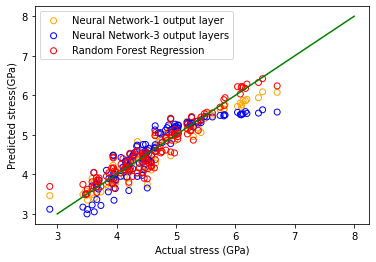

In [82]:
plt.scatter(y_test_stress["stress_yield"],pred_1_stress,label="Neural Network-1 output layer" ,color="orange",facecolors='none') #pred_2
plt.scatter(y_test["stress_yield"],pred_2,label="Neural Network-3 output layers" ,facecolors='none',color="blue")

plt.xlabel('Actual stress (GPa)')
plt.ylabel('Predicted stress(GPa)')
plt.plot([3,8],[3,8],marker=None,color="green")
plt.scatter(y_test["stress_yield"], y_pred_RF[:,1], color="red", label="Random Forest Regression", facecolors='none')
plt.legend()

In [83]:
nn_results_stress = model_nn_stress.predict(x_test_stress)
r2score_nn_stress = r2_score(y_test_stress, nn_results_stress) 
MSE_nn_stress = mean_squared_error(y_test_stress, nn_results_stress)
MAE_nn_stress = mean_absolute_error(y_test_stress, nn_results_stress)
print(r2score_nn_stress,MSE_nn_stress,MAE_nn_stress)

4/4 [==============================] - 0s 8ms/step
0.9036695275326181 0.053865685214605906 0.1815468639359845


# strain

In [84]:
l1=[col for col in data.columns if col not in prop]
#print(l1)
x_strain=data.drop(l1,axis=1)
#print(x)
y_strain=data[["strain_yield"]] #[features]

#y=y.reset_index(drop=True)
#print(y)
x_train_strain, x_test_strain, y_train_strain, y_test_strain = train_test_split(x_strain, y_strain, test_size=0.2, random_state=42,stratify=data["T"])
scaler = StandardScaler()
scaler.fit(x_train_strain)
x_train_strain = scaler.transform(x_train_strain)
x_test_strain = scaler.transform(x_test_strain)
print(x_test_strain)

[[-1.39024343 -1.10369004  0.50243191 -1.34490555]
 [-0.03277588  1.43592862 -0.79813402  1.36799936]
 [-0.71150966  1.62332227 -0.79813402 -0.1059227 ]
 [-1.39024343  0.73671061  1.80299784 -0.91476811]
 [-0.71150966 -1.0805519   0.50243191 -1.23319672]
 [-0.03277588  0.44998222  0.50243191  0.14437856]
 [-1.39024343 -1.78029545  1.80299784 -1.41637249]
 [ 0.6459579   0.71449761 -0.79813402  1.49874378]
 [ 1.32469168 -0.15979203  0.50243191  0.14688324]
 [-1.39024343 -1.76943509 -0.79813402 -1.41587155]
 [-0.03277588 -1.4125604  -0.79813402 -0.8927269 ]
 [-1.39024343 -0.50377445 -0.79813402 -1.2452192 ]
 [-1.39024343 -2.48302982  1.80299784 -1.44843242]
 [ 1.32469168 -0.27659301 -0.79813402  0.96491249]
 [-0.03277588  1.22753437 -0.79813402  1.42226748]
 [-0.71150966  0.76987286  0.50243191  0.68455505]
 [-0.71150966  2.05959492  1.80299784  1.59141703]
 [ 1.32469168 -0.23207532  0.50243191  0.74700513]
 [ 1.32469168  0.0990013   1.80299784  1.52278873]
 [-1.39024343  1.88551027 -0.79

In [85]:
#Create the layers
n1=10 #neuron
n2=20 #neuron
n_input=x_strain.shape[1]
n_output=y_strain.shape[1]
input_layer=Input(shape=(n_input,),name='input_layer')
layer_1=Dense(n1,activation="linear",name='layer_1')(input_layer)
layer_2=Dense(n2,activation="linear",name='layer_2')(layer_1)
layer_3=Dense(n2,activation="linear",name='layer_3')(layer_2)


#1st output
y1_output=Dense(n_output,activation="linear",name='y1_output')(layer_3)


#Define the model
model_nn_strain=Model(inputs=input_layer,outputs=y1_output)#[,y3_output]

#MSummary of Model
model_nn_strain.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 4)]               0         
                                                                 
 layer_1 (Dense)             (None, 10)                50        
                                                                 
 layer_2 (Dense)             (None, 20)                220       
                                                                 
 layer_3 (Dense)             (None, 20)                420       
                                                                 
 y1_output (Dense)           (None, 1)                 21        
                                                                 
Total params: 711
Trainable params: 711
Non-trainable params: 0
_________________________________________________________________


In [86]:
## defining the optimiser and loss function
model_nn_strain.compile(optimizer='adam', loss='mse') #,'y3_output':'mse'

##train the model
history=model_nn_strain.fit(x_train_strain,y_train_strain,epochs=1000, batch_size=128, validation_data=(x_test_strain,y_test_strain))

Epoch 1/1000
4/4 [==============================] - 9s 527ms/step - loss: 0.2227 - val_loss: 0.1457
Epoch 2/1000
4/4 [==============================] - 0s 51ms/step - loss: 0.1145 - val_loss: 0.0736
Epoch 3/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.0575 - val_loss: 0.0365
Epoch 4/1000
4/4 [==============================] - 0s 47ms/step - loss: 0.0299 - val_loss: 0.0239
Epoch 5/1000
4/4 [==============================] - 0s 31ms/step - loss: 0.0228 - val_loss: 0.0220
Epoch 6/1000
4/4 [==============================] - 0s 46ms/step - loss: 0.0219 - val_loss: 0.0216
Epoch 7/1000
4/4 [==============================] - 0s 84ms/step - loss: 0.0208 - val_loss: 0.0191
Epoch 8/1000
4/4 [==============================] - 0s 79ms/step - loss: 0.0173 - val_loss: 0.0148
Epoch 9/1000
4/4 [==============================] - 0s 60ms/step - loss: 0.0126 - val_loss: 0.0103
Epoch 10/1000
4/4 [==============================] - 0s 64ms/step - loss: 0.0086 - val_loss: 0.0071
Epoch 11

4/4 [==============================] - 0s 88ms/step - loss: 4.3671e-05 - val_loss: 3.1110e-05
Epoch 79/1000
4/4 [==============================] - 0s 28ms/step - loss: 4.3167e-05 - val_loss: 3.1571e-05
Epoch 80/1000
4/4 [==============================] - 0s 23ms/step - loss: 4.3562e-05 - val_loss: 3.0990e-05
Epoch 81/1000
4/4 [==============================] - 0s 30ms/step - loss: 4.4108e-05 - val_loss: 3.0734e-05
Epoch 82/1000
4/4 [==============================] - 0s 27ms/step - loss: 4.2917e-05 - val_loss: 3.1604e-05
Epoch 83/1000
4/4 [==============================] - 0s 26ms/step - loss: 4.4242e-05 - val_loss: 3.1175e-05
Epoch 84/1000
4/4 [==============================] - 0s 48ms/step - loss: 4.3715e-05 - val_loss: 3.1319e-05
Epoch 85/1000
4/4 [==============================] - 0s 23ms/step - loss: 4.3467e-05 - val_loss: 3.2248e-05
Epoch 86/1000
4/4 [==============================] - 0s 19ms/step - loss: 4.5679e-05 - val_loss: 3.0561e-05
Epoch 87/1000
4/4 [=======================

4/4 [==============================] - 0s 26ms/step - loss: 4.5384e-05 - val_loss: 3.1705e-05
Epoch 154/1000
4/4 [==============================] - 0s 50ms/step - loss: 4.4772e-05 - val_loss: 3.0943e-05
Epoch 155/1000
4/4 [==============================] - 0s 34ms/step - loss: 4.3708e-05 - val_loss: 3.0975e-05
Epoch 156/1000
4/4 [==============================] - 0s 26ms/step - loss: 4.3773e-05 - val_loss: 3.0986e-05
Epoch 157/1000
4/4 [==============================] - 0s 32ms/step - loss: 4.4318e-05 - val_loss: 3.1784e-05
Epoch 158/1000
4/4 [==============================] - 0s 32ms/step - loss: 4.3923e-05 - val_loss: 3.2038e-05
Epoch 159/1000
4/4 [==============================] - 0s 28ms/step - loss: 4.4018e-05 - val_loss: 3.1664e-05
Epoch 160/1000
4/4 [==============================] - 0s 35ms/step - loss: 4.3617e-05 - val_loss: 3.1154e-05
Epoch 161/1000
4/4 [==============================] - 0s 29ms/step - loss: 4.3575e-05 - val_loss: 3.0563e-05
Epoch 162/1000
4/4 [==============

4/4 [==============================] - 0s 17ms/step - loss: 4.4347e-05 - val_loss: 3.1657e-05
Epoch 229/1000
4/4 [==============================] - 0s 16ms/step - loss: 4.4746e-05 - val_loss: 3.4270e-05
Epoch 230/1000
4/4 [==============================] - 0s 56ms/step - loss: 4.5484e-05 - val_loss: 3.4217e-05
Epoch 231/1000
4/4 [==============================] - 0s 22ms/step - loss: 4.5955e-05 - val_loss: 3.0775e-05
Epoch 232/1000
4/4 [==============================] - 0s 27ms/step - loss: 4.4012e-05 - val_loss: 3.0432e-05
Epoch 233/1000
4/4 [==============================] - 0s 28ms/step - loss: 4.4019e-05 - val_loss: 3.1408e-05
Epoch 234/1000
4/4 [==============================] - 0s 36ms/step - loss: 4.3588e-05 - val_loss: 3.1353e-05
Epoch 235/1000
4/4 [==============================] - 0s 98ms/step - loss: 4.4193e-05 - val_loss: 3.1024e-05
Epoch 236/1000
4/4 [==============================] - 0s 53ms/step - loss: 4.3457e-05 - val_loss: 3.1012e-05
Epoch 237/1000
4/4 [==============

4/4 [==============================] - 0s 22ms/step - loss: 4.6075e-05 - val_loss: 3.2418e-05
Epoch 304/1000
4/4 [==============================] - 0s 22ms/step - loss: 4.3556e-05 - val_loss: 3.3604e-05
Epoch 305/1000
4/4 [==============================] - 0s 18ms/step - loss: 4.4815e-05 - val_loss: 3.8012e-05
Epoch 306/1000
4/4 [==============================] - 0s 19ms/step - loss: 5.0387e-05 - val_loss: 4.9611e-05
Epoch 307/1000
4/4 [==============================] - 0s 21ms/step - loss: 5.3642e-05 - val_loss: 3.7563e-05
Epoch 308/1000
4/4 [==============================] - 0s 23ms/step - loss: 4.8280e-05 - val_loss: 3.3869e-05
Epoch 309/1000
4/4 [==============================] - 0s 22ms/step - loss: 4.7573e-05 - val_loss: 3.2284e-05
Epoch 310/1000
4/4 [==============================] - 0s 27ms/step - loss: 4.7962e-05 - val_loss: 3.3385e-05
Epoch 311/1000
4/4 [==============================] - 0s 45ms/step - loss: 4.5370e-05 - val_loss: 3.3206e-05
Epoch 312/1000
4/4 [==============

4/4 [==============================] - 0s 26ms/step - loss: 4.4988e-05 - val_loss: 3.7808e-05
Epoch 379/1000
4/4 [==============================] - 0s 27ms/step - loss: 4.5306e-05 - val_loss: 3.5839e-05
Epoch 380/1000
4/4 [==============================] - 0s 24ms/step - loss: 4.9151e-05 - val_loss: 3.1164e-05
Epoch 381/1000
4/4 [==============================] - 0s 26ms/step - loss: 4.6530e-05 - val_loss: 4.1750e-05
Epoch 382/1000
4/4 [==============================] - 0s 30ms/step - loss: 5.1457e-05 - val_loss: 3.2896e-05
Epoch 383/1000
4/4 [==============================] - 0s 44ms/step - loss: 4.7448e-05 - val_loss: 3.2481e-05
Epoch 384/1000
4/4 [==============================] - 0s 40ms/step - loss: 4.4522e-05 - val_loss: 3.3363e-05
Epoch 385/1000
4/4 [==============================] - 0s 27ms/step - loss: 4.4801e-05 - val_loss: 3.4475e-05
Epoch 386/1000
4/4 [==============================] - 0s 28ms/step - loss: 4.6600e-05 - val_loss: 3.6814e-05
Epoch 387/1000
4/4 [==============

4/4 [==============================] - 0s 27ms/step - loss: 4.6104e-05 - val_loss: 3.3544e-05
Epoch 454/1000
4/4 [==============================] - 0s 31ms/step - loss: 5.0184e-05 - val_loss: 3.2649e-05
Epoch 455/1000
4/4 [==============================] - 0s 26ms/step - loss: 4.4789e-05 - val_loss: 3.1247e-05
Epoch 456/1000
4/4 [==============================] - 0s 29ms/step - loss: 4.4744e-05 - val_loss: 3.1620e-05
Epoch 457/1000
4/4 [==============================] - 0s 30ms/step - loss: 4.4346e-05 - val_loss: 3.2654e-05
Epoch 458/1000
4/4 [==============================] - 0s 40ms/step - loss: 4.7609e-05 - val_loss: 3.6837e-05
Epoch 459/1000
4/4 [==============================] - 0s 56ms/step - loss: 4.5719e-05 - val_loss: 3.2956e-05
Epoch 460/1000
4/4 [==============================] - 0s 34ms/step - loss: 4.5658e-05 - val_loss: 3.3928e-05
Epoch 461/1000
4/4 [==============================] - 0s 25ms/step - loss: 4.6205e-05 - val_loss: 3.7006e-05
Epoch 462/1000
4/4 [==============

4/4 [==============================] - 0s 40ms/step - loss: 4.6066e-05 - val_loss: 3.7193e-05
Epoch 529/1000
4/4 [==============================] - 0s 25ms/step - loss: 5.0978e-05 - val_loss: 3.2575e-05
Epoch 530/1000
4/4 [==============================] - 0s 28ms/step - loss: 4.9077e-05 - val_loss: 3.6993e-05
Epoch 531/1000
4/4 [==============================] - 0s 25ms/step - loss: 4.5699e-05 - val_loss: 3.5074e-05
Epoch 532/1000
4/4 [==============================] - 0s 25ms/step - loss: 4.5565e-05 - val_loss: 3.2607e-05
Epoch 533/1000
4/4 [==============================] - 0s 43ms/step - loss: 4.5505e-05 - val_loss: 3.2846e-05
Epoch 534/1000
4/4 [==============================] - 0s 37ms/step - loss: 4.5818e-05 - val_loss: 3.3168e-05
Epoch 535/1000
4/4 [==============================] - 0s 39ms/step - loss: 4.5414e-05 - val_loss: 3.4090e-05
Epoch 536/1000
4/4 [==============================] - 0s 85ms/step - loss: 4.7964e-05 - val_loss: 3.6367e-05
Epoch 537/1000
4/4 [==============

4/4 [==============================] - 0s 26ms/step - loss: 7.7104e-05 - val_loss: 4.4132e-05
Epoch 604/1000
4/4 [==============================] - 0s 32ms/step - loss: 6.9484e-05 - val_loss: 5.6509e-05
Epoch 605/1000
4/4 [==============================] - 0s 28ms/step - loss: 6.5961e-05 - val_loss: 6.8185e-05
Epoch 606/1000
4/4 [==============================] - 0s 41ms/step - loss: 6.6626e-05 - val_loss: 3.5974e-05
Epoch 607/1000
4/4 [==============================] - 0s 27ms/step - loss: 5.5191e-05 - val_loss: 3.9179e-05
Epoch 608/1000
4/4 [==============================] - 0s 26ms/step - loss: 5.2776e-05 - val_loss: 4.3637e-05
Epoch 609/1000
4/4 [==============================] - 0s 29ms/step - loss: 5.0413e-05 - val_loss: 4.1698e-05
Epoch 610/1000
4/4 [==============================] - 0s 23ms/step - loss: 5.0424e-05 - val_loss: 3.6088e-05
Epoch 611/1000
4/4 [==============================] - 0s 23ms/step - loss: 4.9874e-05 - val_loss: 3.3097e-05
Epoch 612/1000
4/4 [==============

4/4 [==============================] - 0s 23ms/step - loss: 4.4394e-05 - val_loss: 3.0390e-05
Epoch 679/1000
4/4 [==============================] - 0s 31ms/step - loss: 4.4508e-05 - val_loss: 3.2103e-05
Epoch 680/1000
4/4 [==============================] - 0s 62ms/step - loss: 4.6017e-05 - val_loss: 3.3338e-05
Epoch 681/1000
4/4 [==============================] - 0s 49ms/step - loss: 4.4924e-05 - val_loss: 3.1087e-05
Epoch 682/1000
4/4 [==============================] - 0s 37ms/step - loss: 4.5353e-05 - val_loss: 3.5554e-05
Epoch 683/1000
4/4 [==============================] - 0s 21ms/step - loss: 4.6407e-05 - val_loss: 3.5954e-05
Epoch 684/1000
4/4 [==============================] - 0s 25ms/step - loss: 4.6575e-05 - val_loss: 2.9606e-05
Epoch 685/1000
4/4 [==============================] - 0s 25ms/step - loss: 4.6463e-05 - val_loss: 3.2550e-05
Epoch 686/1000
4/4 [==============================] - 0s 31ms/step - loss: 4.5650e-05 - val_loss: 3.3170e-05
Epoch 687/1000
4/4 [==============

4/4 [==============================] - 0s 18ms/step - loss: 5.2134e-05 - val_loss: 3.7609e-05
Epoch 754/1000
4/4 [==============================] - 0s 22ms/step - loss: 4.9474e-05 - val_loss: 4.9463e-05
Epoch 755/1000
4/4 [==============================] - 0s 23ms/step - loss: 5.9677e-05 - val_loss: 3.2690e-05
Epoch 756/1000
4/4 [==============================] - 0s 20ms/step - loss: 4.8310e-05 - val_loss: 3.8359e-05
Epoch 757/1000
4/4 [==============================] - 0s 18ms/step - loss: 4.5097e-05 - val_loss: 3.1323e-05
Epoch 758/1000
4/4 [==============================] - 0s 21ms/step - loss: 5.0204e-05 - val_loss: 3.3528e-05
Epoch 759/1000
4/4 [==============================] - 0s 24ms/step - loss: 4.9663e-05 - val_loss: 4.5356e-05
Epoch 760/1000
4/4 [==============================] - 0s 17ms/step - loss: 5.0695e-05 - val_loss: 4.0265e-05
Epoch 761/1000
4/4 [==============================] - 0s 20ms/step - loss: 5.2330e-05 - val_loss: 3.5381e-05
Epoch 762/1000
4/4 [==============

4/4 [==============================] - 0s 27ms/step - loss: 5.5420e-05 - val_loss: 3.9015e-05
Epoch 829/1000
4/4 [==============================] - 0s 28ms/step - loss: 5.3897e-05 - val_loss: 4.4100e-05
Epoch 830/1000
4/4 [==============================] - 0s 29ms/step - loss: 6.0768e-05 - val_loss: 5.7645e-05
Epoch 831/1000
4/4 [==============================] - 0s 39ms/step - loss: 5.7296e-05 - val_loss: 4.1959e-05
Epoch 832/1000
4/4 [==============================] - 0s 28ms/step - loss: 5.0396e-05 - val_loss: 3.2329e-05
Epoch 833/1000
4/4 [==============================] - 0s 49ms/step - loss: 4.5706e-05 - val_loss: 3.9325e-05
Epoch 834/1000
4/4 [==============================] - 0s 44ms/step - loss: 5.7281e-05 - val_loss: 3.6211e-05
Epoch 835/1000
4/4 [==============================] - 0s 38ms/step - loss: 5.7294e-05 - val_loss: 3.9212e-05
Epoch 836/1000
4/4 [==============================] - 0s 18ms/step - loss: 5.3734e-05 - val_loss: 5.3557e-05
Epoch 837/1000
4/4 [==============

4/4 [==============================] - 0s 21ms/step - loss: 5.7913e-05 - val_loss: 3.5038e-05
Epoch 904/1000
4/4 [==============================] - 0s 23ms/step - loss: 5.5859e-05 - val_loss: 5.9278e-05
Epoch 905/1000
4/4 [==============================] - 0s 23ms/step - loss: 6.5170e-05 - val_loss: 5.5617e-05
Epoch 906/1000
4/4 [==============================] - 0s 24ms/step - loss: 6.4533e-05 - val_loss: 7.3337e-05
Epoch 907/1000
4/4 [==============================] - 0s 26ms/step - loss: 5.9711e-05 - val_loss: 3.5704e-05
Epoch 908/1000
4/4 [==============================] - 0s 46ms/step - loss: 5.4258e-05 - val_loss: 3.7893e-05
Epoch 909/1000
4/4 [==============================] - 0s 16ms/step - loss: 5.6570e-05 - val_loss: 5.2259e-05
Epoch 910/1000
4/4 [==============================] - 0s 15ms/step - loss: 5.7975e-05 - val_loss: 4.3891e-05
Epoch 911/1000
4/4 [==============================] - 0s 17ms/step - loss: 5.6632e-05 - val_loss: 5.1816e-05
Epoch 912/1000
4/4 [==============

4/4 [==============================] - 0s 36ms/step - loss: 5.8188e-05 - val_loss: 4.1852e-05
Epoch 979/1000
4/4 [==============================] - 0s 20ms/step - loss: 5.6421e-05 - val_loss: 3.7896e-05
Epoch 980/1000
4/4 [==============================] - 0s 28ms/step - loss: 5.3406e-05 - val_loss: 4.5503e-05
Epoch 981/1000
4/4 [==============================] - 0s 22ms/step - loss: 5.2640e-05 - val_loss: 4.2290e-05
Epoch 982/1000
4/4 [==============================] - 0s 21ms/step - loss: 4.7440e-05 - val_loss: 3.1845e-05
Epoch 983/1000
4/4 [==============================] - 0s 17ms/step - loss: 4.7201e-05 - val_loss: 3.3423e-05
Epoch 984/1000
4/4 [==============================] - 0s 16ms/step - loss: 4.4452e-05 - val_loss: 3.2191e-05
Epoch 985/1000
4/4 [==============================] - 0s 17ms/step - loss: 5.0076e-05 - val_loss: 3.1609e-05
Epoch 986/1000
4/4 [==============================] - 0s 16ms/step - loss: 6.6420e-05 - val_loss: 4.2014e-05
Epoch 987/1000
4/4 [==============

In [ ]:
# Evalute the Model
model_nn_strain.evaluate(x_test_strain, y_test_strain)

# Plot loss VS epochs graph
pd.DataFrame(history.history).plot()
plt.ylabel('loss', fontsize=14)
plt.xlabel('epochs', fontsize=14)

In [ ]:
predictions_strain = model_nn_strain .predict(x_test_strain)
pred_1_strain =predictions_strain [:,0]

In [ ]:
plt.scatter(y_test_strain["strain_yield"],pred_1_strain,label="Neural Network-1 output layer",color="orange",facecolors='none') #pred_2
plt.scatter(y_test["strain_yield"],pred_3,label="Neural Network-1 output layers",color="blue",facecolors='none' )
plt.xlabel('Actual strain')
plt.ylabel('Predicted strain')
plt.plot([0.06,0.13],[0.06,0.13],marker=None,color="green")
plt.scatter(y_test["strain_yield"], y_pred_RF[:,2], color="r", label="Random Forest Regression",facecolors='none')
plt.legend()

In [ ]:
nn_results_strain = model_nn_strain.predict(x_test_strain)
r2score_nn_strain = r2_score(y_test_strain, nn_results_strain) 
MSE_nn_strain = mean_squared_error(y_test_strain, nn_results_strain)
MAE_nn_strain = mean_absolute_error(y_test_strain, nn_results_strain)
print(r2score_nn_strain,MSE_nn_strain,MAE_nn_strain)